In [266]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os
import warnings
import matplotlib.pyplot as plt
import datetime as dt
from collections import UserDict
from glob import glob
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series
warnings.filterwarnings("ignore")
#import pandas_bokeh
#pandas_bokeh.output_notebook()
#pd.set_option("plotting.backend", "pandas_bokeh")

### Sommaire

* [Explorer les données](#explorer_data)
    * [Eau](#Eau_data)
    * [Elec](#Elec_data)
    * [Gaz](#Gaz_data)
* [Feature engineering](#ft_engi)
    * [Température](#temp)
    * [Humidité et Précipitation](#humid_precip)
    * [Vacances, Weekend, Distanciel](#Vac)
* [Evaluation des features](#eval_feat)
    * [Eau](#Eau_feat)
    * [Elec](#Elec_feat)
    * [Gaz](#Gaz_feat)
* [Creation des modèles](#model)
    * [Elec](#Elec_model)
        * [Naive](#Elec_naive)
        * [Deep learning](#Elec_deep)
        * [Statistique](#Elec_stat)
    * [Eau](#Eau_model)
        * [Naive](#Eau_naive)
        * [Deep learning](#Eau_deep)
        * [Statistique](#Eau_stat)
    * [Gaz](#Gaz_model) 
        * [Naive](#Gaz_naive)
        * [Deep learning](#Gaz_deep)
        * [Statistique](#Gaz_stat)

# Explorer les données <a class="anchor" id="explorer_data"></a>

## Eau <a class="anchor" id="Eau_data"></a>

In [2]:
eau_ESIEE = pd.read_csv("Eau_ESIEE_df.csv")
eau_ESIEE

Unnamed: 0     m3 E/M
0     2019-11-01  31.46   E
1     2019-11-02  21.76   E
2     2019-11-03  18.02   E
3     2019-11-04  29.98   E
4     2019-11-05  28.59   E
...          ...    ...  ..
1041  2022-09-09  16.08   M
1042  2022-09-10  18.25   M
1043  2022-09-11  31.56   M
1044  2022-09-12  26.90   M
1045  2022-09-13  29.65   M

[1046 rows x 3 columns]

In [3]:
eau_ESIEE.isna().sum()
#eau_ESIEE.dropna(inplace=True)

Unnamed: 0    0
m3            0
E/M           0
dtype: int64

In [4]:
eau_ESIEE.rename(columns={"Unnamed: 0": "date"},inplace=True)
eau_ESIEE["date"]= pd.to_datetime(eau_ESIEE["date"],format="%Y-%m-%d")
eau_ESIEE.set_index("date", inplace=True)
eau_ESIEE

m3 E/M
date                 
2019-11-01  31.46   E
2019-11-02  21.76   E
2019-11-03  18.02   E
2019-11-04  29.98   E
2019-11-05  28.59   E
...           ...  ..
2022-09-09  16.08   M
2022-09-10  18.25   M
2022-09-11  31.56   M
2022-09-12  26.90   M
2022-09-13  29.65   M

[1046 rows x 2 columns]

<AxesSubplot:xlabel='date'>

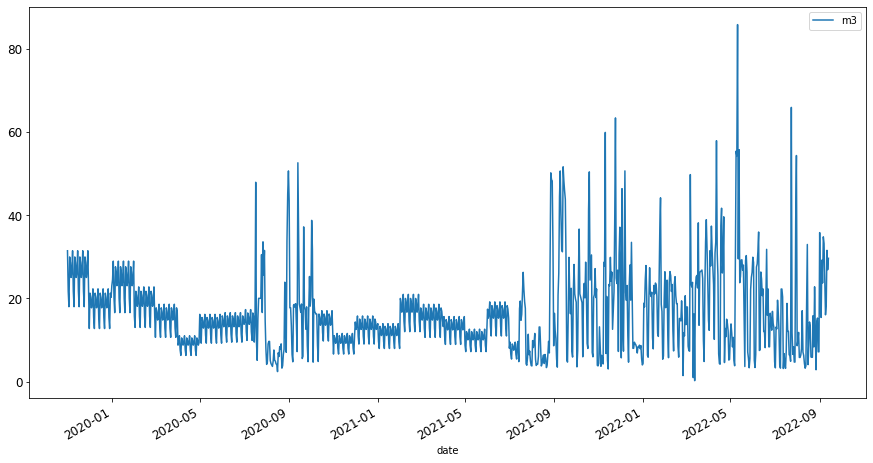

In [5]:
eau_ESIEE.plot(figsize=(15, 8), fontsize=12)

In [6]:
range_date = pd.date_range(start=eau_ESIEE.index.min(), end=eau_ESIEE.index.max())
missing_date = eau_ESIEE.reindex(range_date).isnull().all(1)
missing_date[missing_date == True]

2022-03-21    True
2022-03-22    True
Freq: D, dtype: bool

In [7]:
eau_ESIEE=eau_ESIEE.reindex(range_date)
eau_ESIEE['m3_ma']=eau_ESIEE['m3'].rolling(4,min_periods=2).mean()
eau_ESIEE['m3'].fillna(eau_ESIEE['m3_ma'],inplace=True)
eau_ESIEE['E/M'].fillna(method='ffill',inplace=True)
eau_ESIEE.drop(['m3_ma'],axis=1,inplace=True)
missing_date = eau_ESIEE.reindex(range_date).isnull().all(1)
missing_date[missing_date == True]

Series([], Freq: D, dtype: bool)

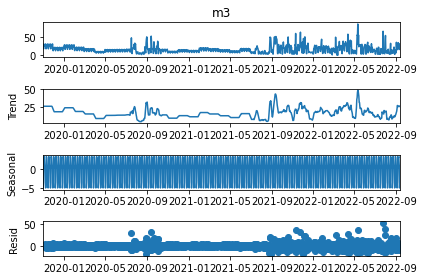

In [8]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(eau_ESIEE['m3'])
out.plot();

<AxesSubplot:>

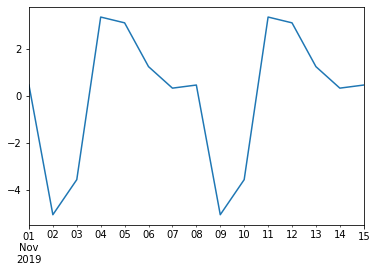

In [9]:
out.seasonal[:15].plot()

<AxesSubplot:xlabel='day_week'>

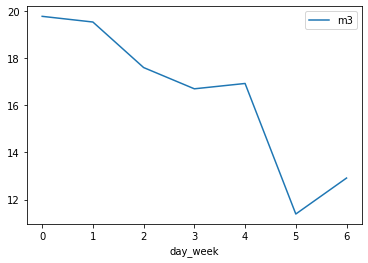

In [10]:
eau_ESIEE['day_week'] = eau_ESIEE.index.dayofweek
eau_ESIEE[['m3','day_week']].groupby(by="day_week").mean().plot()

<AxesSubplot:xlabel='month'>

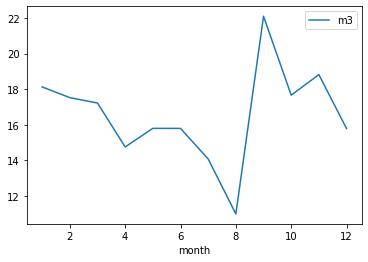

In [11]:
eau_ESIEE['month'] = eau_ESIEE.index.month
eau_ESIEE[['m3','month']].groupby(by="month").mean().plot()

In [12]:
Map = {'E': 0, 'M': 1}
eau_ESIEE=eau_ESIEE.applymap(lambda x: Map.get(x) if x in Map else x)

## Electricité  <a class="anchor" id="Elec_data"></a>

In [13]:
elec_ESIEE = pd.read_csv("Elec_ESIEE_df.csv")
elec_ESIEE

datetime     kW   kVAr   V
0       2016-02-01 00:00:00  504.0  234.0 NaN
1       2016-02-01 00:10:00  606.0  304.0 NaN
2       2016-02-01 00:20:00  555.0  257.0 NaN
3       2016-02-01 00:30:00  519.0  225.0 NaN
4       2016-02-01 00:40:00  518.0  225.0 NaN
...                     ...    ...    ...  ..
337920  2022-07-05 23:10:00  272.0    NaN NaN
337921  2022-07-05 23:20:00  279.0    NaN NaN
337922  2022-07-05 23:30:00  292.0    NaN NaN
337923  2022-07-05 23:40:00  273.0    NaN NaN
337924  2022-07-05 23:50:00  280.0    NaN NaN

[337925 rows x 4 columns]

In [14]:
elec_ESIEE.isna().sum()

datetime         0
kW           18422
kVAr         45236
V           168560
dtype: int64

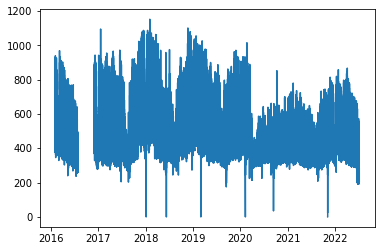

In [15]:
elec_ESIEE["datetime"]= pd.to_datetime(elec_ESIEE["datetime"],format="%Y-%m-%d %H:%M:%S")
elec_ESIEE = elec_ESIEE.drop(["kVAr","V"],axis=1)
plt.plot(elec_ESIEE['datetime'],elec_ESIEE['kW'])

In [16]:
elec_ESIEE

datetime     kW
0      2016-02-01 00:00:00  504.0
1      2016-02-01 00:10:00  606.0
2      2016-02-01 00:20:00  555.0
3      2016-02-01 00:30:00  519.0
4      2016-02-01 00:40:00  518.0
...                    ...    ...
337920 2022-07-05 23:10:00  272.0
337921 2022-07-05 23:20:00  279.0
337922 2022-07-05 23:30:00  292.0
337923 2022-07-05 23:40:00  273.0
337924 2022-07-05 23:50:00  280.0

[337925 rows x 2 columns]

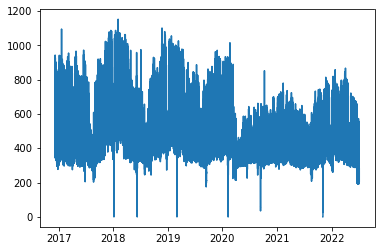

In [17]:
elec_ESIEE = elec_ESIEE[elec_ESIEE['datetime']>='2016-12-05']
plt.plot(elec_ESIEE['datetime'],elec_ESIEE['kW'])

In [18]:
elec_ESIEE[elec_ESIEE['kW'].isna()]

datetime  kW
302846 2021-11-04 08:20:00 NaN
302847 2021-11-04 08:30:00 NaN
302848 2021-11-04 08:40:00 NaN
302849 2021-11-04 08:50:00 NaN
302850 2021-11-04 09:00:00 NaN
302851 2021-11-04 09:10:00 NaN
302852 2021-11-04 09:20:00 NaN
302853 2021-11-04 09:30:00 NaN
302854 2021-11-04 09:40:00 NaN
302855 2021-11-04 09:50:00 NaN
302856 2021-11-04 10:00:00 NaN
302857 2021-11-04 10:10:00 NaN
302858 2021-11-04 10:20:00 NaN
302859 2021-11-04 10:30:00 NaN
302860 2021-11-04 10:40:00 NaN
302861 2021-11-04 10:50:00 NaN
302862 2021-11-04 11:00:00 NaN
302863 2021-11-04 11:10:00 NaN
302864 2021-11-04 11:20:00 NaN
302865 2021-11-04 11:30:00 NaN
302866 2021-11-04 11:40:00 NaN

C:\Users\Evalk\AppData\Local\Temp/ipykernel_49580/1766046841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_ESIEE['kW_ma']=elec_ESIEE.loc[:,'kW'].rolling(24,min_periods=2).mean()
C:\Users\Evalk\AppData\Local\Temp/ipykernel_49580/1766046841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_ESIEE['kW'].fillna(elec_ESIEE['kW_ma'],inplace=True)
C:\Users\Evalk\AppData\Local\Temp/ipykernel_49580/1766046841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

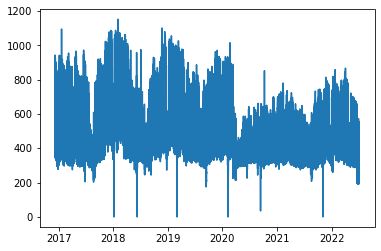

In [19]:
elec_ESIEE['kW_ma']=elec_ESIEE.loc[:,'kW'].rolling(24,min_periods=2).mean()
elec_ESIEE['kW'].fillna(elec_ESIEE['kW_ma'],inplace=True)
elec_ESIEE.drop(['kW_ma'],axis=1,inplace=True)
plt.plot(elec_ESIEE['datetime'],elec_ESIEE['kW'])

<AxesSubplot:xlabel='datetime'>

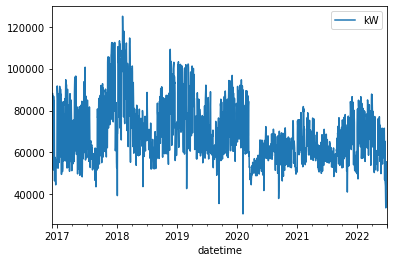

In [20]:
elec_ESIEE = elec_ESIEE.groupby(pd.Grouper(key='datetime', axis=0, freq='D')).sum()

elec_ESIEE.plot()

In [21]:
range_date = pd.date_range(start=elec_ESIEE.index.min(), end=elec_ESIEE.index.max())
missing_date = elec_ESIEE.reindex(range_date).isnull().all(1)
missing_date[missing_date == True]

Series([], Freq: D, dtype: bool)

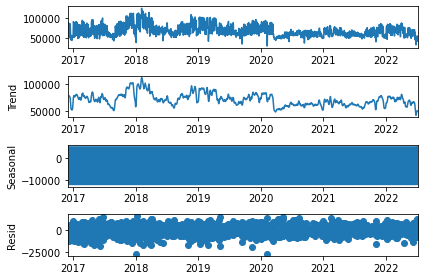

In [22]:
out = seasonal_decompose(elec_ESIEE)
out.plot();

<AxesSubplot:xlabel='datetime'>

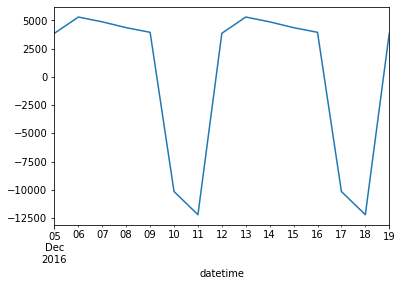

In [23]:
out.seasonal[:15].plot()

<AxesSubplot:xlabel='day_week'>

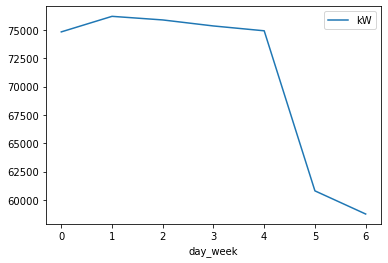

In [24]:
elec_ESIEE['day_week'] = elec_ESIEE.index.dayofweek
elec_ESIEE[['kW','day_week']].groupby(by="day_week").mean().plot()

<AxesSubplot:xlabel='month'>

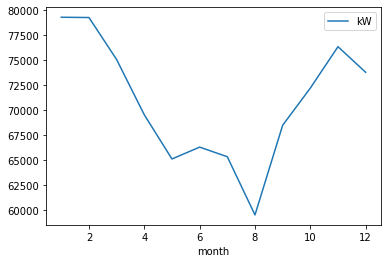

In [25]:
elec_ESIEE['month'] = elec_ESIEE.index.month
elec_ESIEE[['kW','month']].groupby(by="month").mean().plot()

## GAZ  <a class="anchor" id="Gaz_data"></a>

In [26]:
gaz_ESIEE = pd.read_csv("Gaz_ESIEE_df.csv")
gaz_ESIEE

Unnamed: 0     m3    Nm3     kWh E/M
0     2017-10-15  265.0  326.0  3736.0   E
1     2017-10-16  265.0  326.0  3736.0   E
2     2017-10-17  265.0  326.0  3736.0   E
3     2017-10-18  265.0  326.0  3736.0   E
4     2017-10-19  265.0  326.0  3736.0   E
...          ...    ...    ...     ...  ..
1672  2022-05-20  253.0  311.0  3579.0   M
1673  2022-05-21  240.0  295.0  3395.0   M
1674  2022-05-22  226.0  278.0  3197.0   M
1675  2022-05-23  255.0  313.0  3607.0   M
1676  2022-05-24  155.0  190.0  2193.0   M

[1677 rows x 5 columns]

In [27]:
gaz_ESIEE.rename(columns={"Unnamed: 0": "datetime"},inplace=True)
gaz_ESIEE.isna().sum()

datetime     0
m3          42
Nm3         42
kWh         42
E/M          0
dtype: int64

<AxesSubplot:xlabel='datetime'>

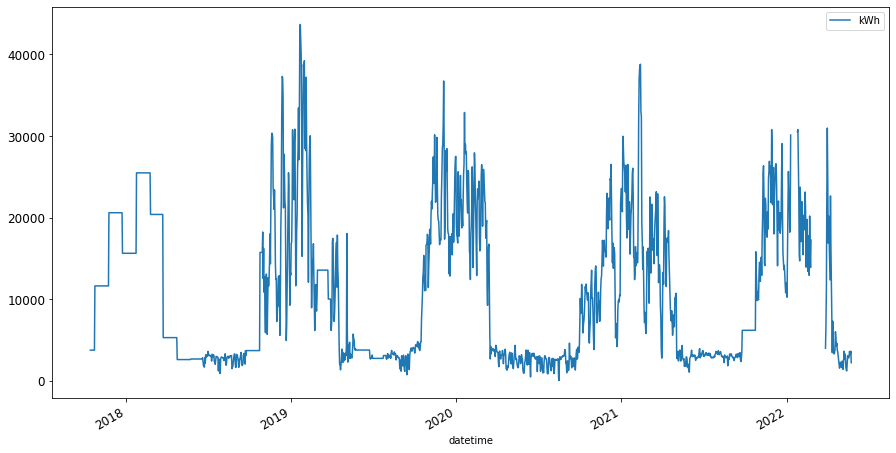

In [28]:
gaz_ESIEE["datetime"]= pd.to_datetime(gaz_ESIEE["datetime"],format="%Y-%m-%d")
gaz_ESIEE.set_index("datetime", inplace=True)
gaz_ESIEE = gaz_ESIEE.drop(["Nm3","m3"],axis=1)
gaz_ESIEE.plot(figsize=(15, 8), fontsize=12)

In [29]:
gaz_ESIEE[gaz_ESIEE['kWh'].isna()]

kWh E/M
datetime           
2022-01-11  NaN   E
2022-01-12  NaN   E
2022-01-13  NaN   E
2022-01-14  NaN   E
2022-01-15  NaN   E
2022-01-16  NaN   E
2022-01-17  NaN   E
2022-01-18  NaN   E
2022-01-19  NaN   E
2022-01-20  NaN   E
2022-01-21  NaN   E
2022-01-22  NaN   E
2022-01-23  NaN   E
2022-01-24  NaN   E
2022-02-25  NaN   E
2022-02-26  NaN   E
2022-02-27  NaN   E
2022-02-28  NaN   E
2022-03-01  NaN   E
2022-03-02  NaN   E
2022-03-03  NaN   E
2022-03-04  NaN   E
2022-03-05  NaN   E
2022-03-06  NaN   E
2022-03-07  NaN   E
2022-03-08  NaN   E
2022-03-09  NaN   E
2022-03-10  NaN   E
2022-03-11  NaN   E
2022-03-12  NaN   E
2022-03-13  NaN   E
2022-03-14  NaN   E
2022-03-15  NaN   E
2022-03-16  NaN   E
2022-03-17  NaN   E
2022-03-18  NaN   E
2022-03-19  NaN   E
2022-03-20  NaN   E
2022-03-21  NaN   E
2022-03-22  NaN   E
2022-03-23  NaN   E
2022-03-24  NaN   E

In [30]:
range_date = pd.date_range(start=gaz_ESIEE.index.min(), end=gaz_ESIEE.index.max())
missing_date = gaz_ESIEE.reindex(range_date).isnull().all(1)
missing_date[missing_date == True]

2022-03-25    True
2022-03-26    True
2022-03-27    True
2022-04-25    True
2022-04-26    True
2022-04-27    True
dtype: bool

In [31]:
gaz_ESIEE=gaz_ESIEE.reindex(range_date)
gaz_ESIEE['kWh_ma']=gaz_ESIEE['kWh'].rolling(33,min_periods=2).mean()
gaz_ESIEE['kWh'].fillna(gaz_ESIEE['kWh_ma'],inplace=True)
gaz_ESIEE.drop(['kWh_ma'],axis=1,inplace=True)

In [32]:
gaz_ESIEE[gaz_ESIEE['kWh'].isna()]

Empty DataFrame
Columns: [kWh, E/M]
Index: []

<AxesSubplot:>

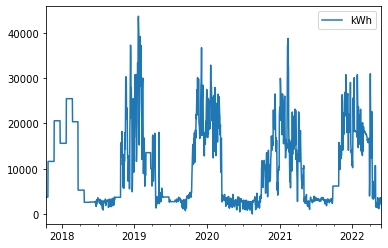

In [33]:
gaz_ESIEE.plot()

<AxesSubplot:>

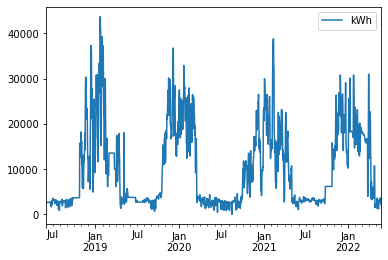

In [34]:
gaz_ESIEE = gaz_ESIEE[gaz_ESIEE.index >='2018-06-01']
gaz_ESIEE.plot()

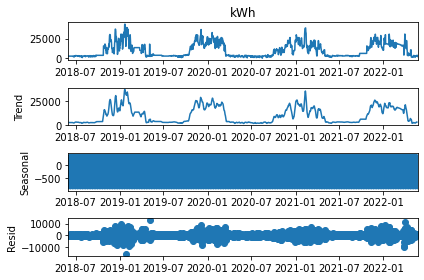

In [35]:
out = seasonal_decompose(gaz_ESIEE['kWh'])
out.plot();

<AxesSubplot:>

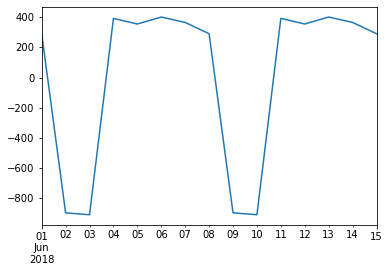

In [36]:
out.seasonal[:15].plot()

<AxesSubplot:xlabel='day_week'>

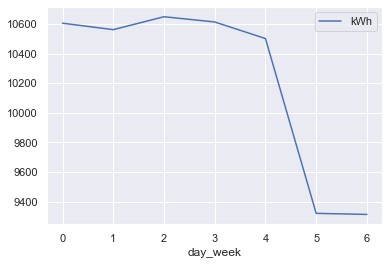

In [268]:
gaz_ESIEE['day_week'] = gaz_ESIEE.index.dayofweek
gaz_ESIEE[['kWh','day_week']].groupby(by="day_week").mean().plot()

<AxesSubplot:xlabel='month'>

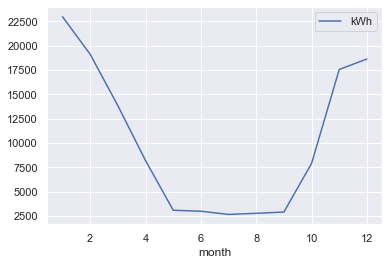

In [269]:
gaz_ESIEE['month'] = gaz_ESIEE.index.month
gaz_ESIEE[['kWh','month']].groupby(by="month").mean().plot()

In [39]:
Map = {'E': 0, 'M': 1}
gaz_ESIEE=gaz_ESIEE.applymap(lambda x: Map.get(x) if x in Map else x)

# Feature engineering  <a class="anchor" id="ft_engi"></a>

# Température <a class="anchor" id="temp"></a>

https://www.data.gouv.fr/fr/datasets/temperature-quotidienne-departementale-depuis-janvier-2018/

In [40]:
temp = pd.read_csv('Temp_departement.csv',sep=';')
temp = temp.loc[temp['code_insee_departement']=='93'].copy()
temp["date_obs"]= pd.to_datetime(temp["date_obs"],format="%Y-%m-%d")
temp.set_index("date_obs", inplace=True)
range_date = pd.date_range(start=temp.index.min(), end=temp.index.max())
missing_date = temp.reindex(range_date).isnull().all(1)
missing_date[missing_date == True]

Series([], Freq: D, dtype: bool)

<AxesSubplot:>

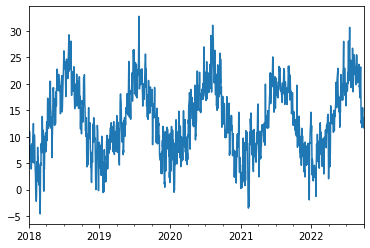

In [41]:
temp = temp.reindex(range_date)['tmoy']
temp.plot()

# Humidité et Précipitation <a class="anchor" id="humid_precip"></a>

In [42]:
meteo = pd.read_csv("Meteo_ORLY_df.csv",sep=";")
meteo

Unnamed: 0  ID OMM station                       Date  \
0              12            7149  2013-04-04T05:00:00+02:00   
1              78            7149  2010-01-23T16:00:00+01:00   
2             104            7149  2010-01-20T13:00:00+01:00   
3             131            7149  2010-01-18T04:00:00+01:00   
4             143            7149  2010-01-29T16:00:00+01:00   
...           ...             ...                        ...   
37466     2165145            7149  2022-03-10T10:00:00+01:00   
37467     2165152            7149  2022-03-11T07:00:00+01:00   
37468     2165193            7149  2022-03-13T19:00:00+01:00   
37469     2165410            7149  2022-02-13T07:00:00+01:00   
37470     2165500            7149  2022-01-07T10:00:00+01:00   

       Pression au niveau mer  Variation de pression en 3 heures  \
0                    100750.0                             -110.0   
1                    102000.0                             -110.0   
2                    101070.0                              -70.0   
3                    102710.0                               20.0   
4                     98690.0                             -220.0   
...                       ...                                ...   
37466                102160.0                               30.0   
37467                101130.0                             -130.0   
37468                101320.0                              220.0   
37469                101750.0                             -190.0   
37470                101800.0                               50.0   

       Type de tendance barométrique  Direction du vent moyen 10 mn  \
0                                6.0                           30.0   
1                                6.0                          130.0   
2                                6.0                          190.0   
3                                2.0                          140.0   
4                                5.0                          270.0   
...                              ...                            ...   
37466                            0.0                          140.0   
37467                            6.0                          130.0   
37468                            3.0                          200.0   
37469                            7.0                          170.0   
37470                            3.0                          220.0   

       Vitesse du vent moyen 10 mn  Température  Point de rosée  ...  \
0                              4.1       274.05          272.85  ...   
1                              2.1       277.45          275.95  ...   
2                              2.1       274.45          274.05  ...   
3                              1.0       273.85          273.55  ...   
4                              4.6       279.55          278.15  ...   
...                            ...          ...             ...  ...   
37466                          2.6       283.05          276.75  ...   
37467                          2.5       279.85          277.15  ...   
37468                          2.8       280.85          279.95  ...   
37469                          2.5       272.45          270.25  ...   
37470                          4.2       277.45          276.85  ...   

       Altitude  communes (name)  communes (code)               EPCI (name)  \
0            89       Athis-Mons            91027  Métropole du Grand Paris   
1            89       Athis-Mons            91027  Métropole du Grand Paris   
2            89       Athis-Mons            91027  Métropole du Grand Paris   
3            89       Athis-Mons            91027  Métropole du Grand Paris   
4            89       Athis-Mons            91027  Métropole du Grand Paris   
...         ...              ...              ...                       ...   
37466        89       Athis-Mons            91027  Métropole du Grand Paris   
37467        89       Athis-Mons            91027  Métropole du Grand P

In [43]:
meteo["Date"]= pd.to_datetime(meteo["Date"],format="%Y-%m-%dT%H:%M:%S%z")


In [44]:
meteo = meteo[meteo['Date'] >= dt.datetime.strptime("2016-01-01T00:00:00+02:00","%Y-%m-%dT%H:%M:%S%z")].copy()
meteo

Unnamed: 0  ID OMM station                       Date  \
483         29545            7149  2017-09-30 17:00:00+02:00   
484         29696            7149  2017-10-08 20:00:00+02:00   
485         29766            7149  2017-10-21 05:00:00+02:00   
486         29976            7149  2017-11-30 13:00:00+01:00   
487         30016            7149  2017-12-02 19:00:00+01:00   
...           ...             ...                        ...   
37466     2165145            7149  2022-03-10 10:00:00+01:00   
37467     2165152            7149  2022-03-11 07:00:00+01:00   
37468     2165193            7149  2022-03-13 19:00:00+01:00   
37469     2165410            7149  2022-02-13 07:00:00+01:00   
37470     2165500            7149  2022-01-07 10:00:00+01:00   

       Pression au niveau mer  Variation de pression en 3 heures  \
483                  101930.0                                0.0   
484                  102150.0                               90.0   
485                  101180.0                             -160.0   
486                  101050.0                              -90.0   
487                  102880.0                              100.0   
...                       ...                                ...   
37466                102160.0                               30.0   
37467                101130.0                             -130.0   
37468                101320.0                              220.0   
37469                101750.0                             -190.0   
37470                101800.0                               50.0   

       Type de tendance barométrique  Direction du vent moyen 10 mn  \
483                              5.0                          270.0   
484                              3.0                          300.0   
485                              6.0                          180.0   
486                              8.0                          300.0   
487                              3.0                          320.0   
...                              ...                            ...   
37466                            0.0                          140.0   
37467                            6.0                          130.0   
37468                            3.0                          200.0   
37469                            7.0                          170.0   
37470                            3.0                          220.0   

       Vitesse du vent moyen 10 mn  Température  Point de rosée  ...  \
483                            3.5       291.15          281.15  ...   
484                            2.9       287.45          283.65  ...   
485                            1.9       286.45          284.55  ...   
486                            4.5       276.95          273.25  ...   
487                            2.5       273.15          270.75  ...   
...                            ...          ...             ...  ...   
37466                          2.6       283.05          276.75  ...   
37467                          2.5       279.85          277.15  ...   
37468                          2.8       280.85          279.95  ...   
37469                          2.5       272.45          270.25  ...   
37470                          4.2       277.45          276.85  ...   

       Altitude  communes (name)  communes (code)               EPCI (name)  \
483          89       Athis-Mons            91027  Métropole du Grand Paris   
484          89       Athis-Mons            91027  Métropole du Grand Paris   
485          89       Athis-Mons            91027  Métropole du Grand Paris   
486          89       Athis-Mons            91027  Métropole du Grand Paris   
487          89       Athis-Mons            91027  Métropole du Grand Paris   
...         ...              ...              ...                       ...   
37466        89       Athis-Mons            91027  Métropole du Grand Paris   
37467        89       Athis-Mons            91027  Métropole du Grand P

In [45]:
meteo['Date'] = meteo['Date'].apply(lambda x: x.date())
range_date = pd.date_range(start=meteo['Date'].min(), end=meteo['Date'].max())
meteo.drop_duplicates('Date',inplace=True)

In [46]:
meteo.set_index("Date", inplace=True)
meteo

Unnamed: 0  ID OMM station  Pression au niveau mer  \
Date                                                             
2017-09-30       29545            7149                101930.0   
2017-10-08       29696            7149                102150.0   
2017-10-21       29766            7149                101180.0   
2017-11-30       29976            7149                101050.0   
2017-12-02       30016            7149                102880.0   
...                ...             ...                     ...   
2020-11-05     1797165            7149                103490.0   
2021-03-08     1811607            7149                102280.0   
2020-01-23     1836944            7149                103120.0   
2020-12-27     1839569            7149                 97860.0   
2019-02-25     1863334            7149                103630.0   

            Variation de pression en 3 heures  Type de tendance barométrique  \
Date                                                                           
2017-09-30                                0.0                            5.0   
2017-10-08                               90.0                            3.0   
2017-10-21                             -160.0                            6.0   
2017-11-30                              -90.0                            8.0   
2017-12-02                              100.0                            3.0   
...                                       ...                            ...   
2020-11-05                             -170.0                            6.0   
2021-03-08                              -80.0                            8.0   
2020-01-23                               10.0                            3.0   
2020-12-27                               10.0                            3.0   
2019-02-25                               90.0                            3.0   

            Direction du vent moyen 10 mn  Vitesse du vent moyen 10 mn  \
Date                                                                     
2017-09-30                          270.0                          3.5   
2017-10-08                          300.0                          2.9   
2017-10-21                          180.0                          1.9   
2017-11-30                          300.0                          4.5   
2017-12-02                          320.0                          2.5   
...                                   ...                          ...   
2020-11-05                           40.0                          6.2   
2021-03-08                           10.0                          2.8   
2020-01-23                           40.0                          5.5   
2020-12-27                          230.0                          4.1   
2019-02-25                           70.0                          3.7   

            Température  Point de rosée  Humidité  ...  Altitude  \
Date                                               ...             
2017-09-30       291.15          281.15      52.0  ...        89   
2017-10-08       287.45          283.65      78.0  ...        89   
2017-10-21       286.45          284.55      88.0  ...        89   
2017-11-30       276.95          273.25      77.0  ...        89   
2017-12-02       273.15          270.75      84.0  ...        89   
...                 ...             ...       ...  ...       ...   
2020-11-05       284.55          276.85      59.0  ...        89   
2021-03-08       272.45          269.55      81.0  ...        89   
2020-01-23       273.55          272.55      93.0  ...        89   
2020-12-27       277.35          276.35      93.0  ...        89   
2019-02-25       282.05          269.45      41.0  ...        89   

            communes (name)  communes (code)               EPCI (name)  \
Date                                                                     
2017-09-30       Athis-Mons            91027  Métropole du Grand Paris   
2017-10-08       Athis-Mons            910

In [47]:
meteo.reindex(range_date)

Unnamed: 0  ID OMM station  Pression au niveau mer  \
2016-01-01      112070            7149                101480.0   
2016-01-02      184978            7149                100790.0   
2016-01-03       35076            7149                 99170.0   
2016-01-04       76117            7149                 99160.0   
2016-01-05      236267            7149                 99200.0   
...                ...             ...                     ...   
2022-10-31     1517509            7149                102100.0   
2022-11-01     1572676            7149                101930.0   
2022-11-02     1535253            7149                102390.0   
2022-11-03     1441654            7149                100580.0   
2022-11-04     1441678            7149                101230.0   

            Variation de pression en 3 heures  Type de tendance barométrique  \
2016-01-01                             -320.0                            8.0   
2016-01-02                              -20.0                            8.0   
2016-01-03                             -390.0                            6.0   
2016-01-04                               10.0                            0.0   
2016-01-05                               90.0                            3.0   
...                                       ...                            ...   
2022-10-31                              -50.0                            8.0   
2022-11-01                                0.0                            0.0   
2022-11-02                              190.0                            1.0   
2022-11-03                              250.0                            3.0   
2022-11-04                              370.0                            1.0   

            Direction du vent moyen 10 mn  Vitesse du vent moyen 10 mn  \
2016-01-01                          130.0                          4.6   
2016-01-02                          210.0                          7.7   
2016-01-03                          190.0                          6.1   
2016-01-04                          220.0                          4.7   
2016-01-05                          210.0                          5.6   
...                                   ...                          ...   
2022-10-31                          130.0                          1.1   
2022-11-01                          210.0                          8.1   
2022-11-02                          220.0                          1.6   
2022-11-03                          230.0                          4.3   
2022-11-04                          330.0                          7.7   

            Température  Point de rosée  Humidité  ...  Altitude  \
2016-01-01       280.05          278.15      88.0  ...        89   
2016-01-02       283.75          279.15      73.0  ...        89   
2016-01-03       280.05          279.45      96.0  ...        89   
2016-01-04       278.85          277.65      92.0  ...        89   
2016-01-05       279.75          278.35      91.0  ...        89   
...                 ...             ...       ...  ...       ...   
2022-10-31       285.25          284.75      97.0  ...        89   
2022-11-01       289.75          282.95      64.0  ...        89   
2022-11-02       282.65          281.55      93.0  ...        89   
2022-11-03       283.55          281.95      90.0  ...        89   
2022-11-04       284.75          282.35      85.0  ...        89   

            communes (name)  communes (code)               EPCI (name)  \
2016-01-01       Athis-Mons            91027  Métropole du Grand Paris   
2016-01-02       Athis-Mons            91027  Métropole du Grand Paris   
2016-01-03       Athis-Mons            91027  Métropole du Grand Paris   
2016-01-04       Athis-Mons            91027  Métropole du Grand Paris   
2016-01-05       Athis-Mons            91027  Métropole du Grand Paris   
...                     ...              ...                       ...   
2022-10-31       Athis-Mons       

<AxesSubplot:xlabel='Date'>

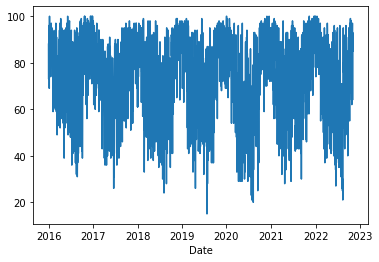

In [48]:
meteo['Humidité'].plot()

<AxesSubplot:xlabel='Date'>

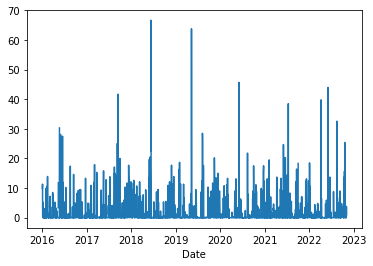

In [49]:
meteo.rename(columns={'Précipitations dans les 24 dernières heures': 'precip24'},inplace=True)
meteo['precip24'].plot()

## Vacances, Weekend et Distanciel <a class="anchor" id="Vac"></a>

On ajoute les conditions weekend, distanciel et vacances vu plus bas

# Evaluation des features <a class="anchor" id="eval_feat"></a>

## EAU <a class="anchor" id="Eau_feat"></a>

In [50]:
train_eau = eau_ESIEE.copy()
train_eau.head(10)

m3  E/M  day_week  month
2019-11-01  31.46    0         4     11
2019-11-02  21.76    0         5     11
2019-11-03  18.02    0         6     11
2019-11-04  29.98    0         0     11
2019-11-05  28.59    0         1     11
2019-11-06  25.04    0         2     11
2019-11-07  26.64    0         3     11
2019-11-08  31.46    0         4     11
2019-11-09  21.76    0         5     11
2019-11-10  18.02    0         6     11

In [51]:
conditions_weekend = ((train_eau['day_week'] == 5) | (train_eau['day_week'] == 6))


conditions_distanciel = (((train_eau.index >= '2022-09') & (train_eau['day_week'] == 2)) #E5
                          |((train_eau.index < '2022-09') & (train_eau.index >= '2021-09') & (train_eau['day_week'] == 0)) #E4
                          |((train_eau.index < '2021-07') & (train_eau.index >= '2021-02') & ((train_eau['day_week'] == 0)|(train_eau['day_week'] == 4))) #E3 Reprise
                          |((train_eau.index < '2021-02') & (train_eau.index >= '2020-11')) #E3 Full distanciel
                          |((train_eau.index < '2020-11') & (train_eau.index >= '2020-09') & ((train_eau['day_week'] == 0)|(train_eau['day_week'] == 4))) #E3 P1           
                        )

conditions_vacances = ((train_eau.index.month >= 7) & (train_eau.index.month < 9))

train_eau['weekend'] = np.where(conditions_weekend, 1, 0)
train_eau['distanciel'] = np.where(conditions_distanciel, 1 , 0)
train_eau['vacances'] = np.where(conditions_distanciel, 1 , 0)

train_eau = train_eau.join(temp)
train_eau = train_eau.join(meteo[['Humidité','precip24']])

train_eau.head(10)

m3  E/M  day_week  month  weekend  distanciel  vacances   tmoy  \
2019-11-01  31.46    0         4     11        0           0         0  13.20   
2019-11-02  21.76    0         5     11        1           0         0  13.60   
2019-11-03  18.02    0         6     11        1           0         0  12.05   
2019-11-04  29.98    0         0     11        0           0         0  12.55   
2019-11-05  28.59    0         1     11        0           0         0  10.35   
2019-11-06  25.04    0         2     11        0           0         0  10.25   
2019-11-07  26.64    0         3     11        0           0         0  10.15   
2019-11-08  31.46    0         4     11        0           0         0   6.45   
2019-11-09  21.76    0         5     11        1           0         0   6.25   
2019-11-10  18.02    0         6     11        1           0         0   6.60   

            Humidité  precip24  
2019-11-01      98.0      11.7  
2019-11-02      89.0       1.2  
2019-11-03      92.0       0.8  
2019-11-04      87.0       6.0  
2019-11-05      94.0       0.8  
2019-11-06      72.0       0.2  
2019-11-07      91.0       8.9  
2019-11-08      81.0       0.0  
2019-11-09      87.0      -0.1  
2019-11-10      96.0       3.4

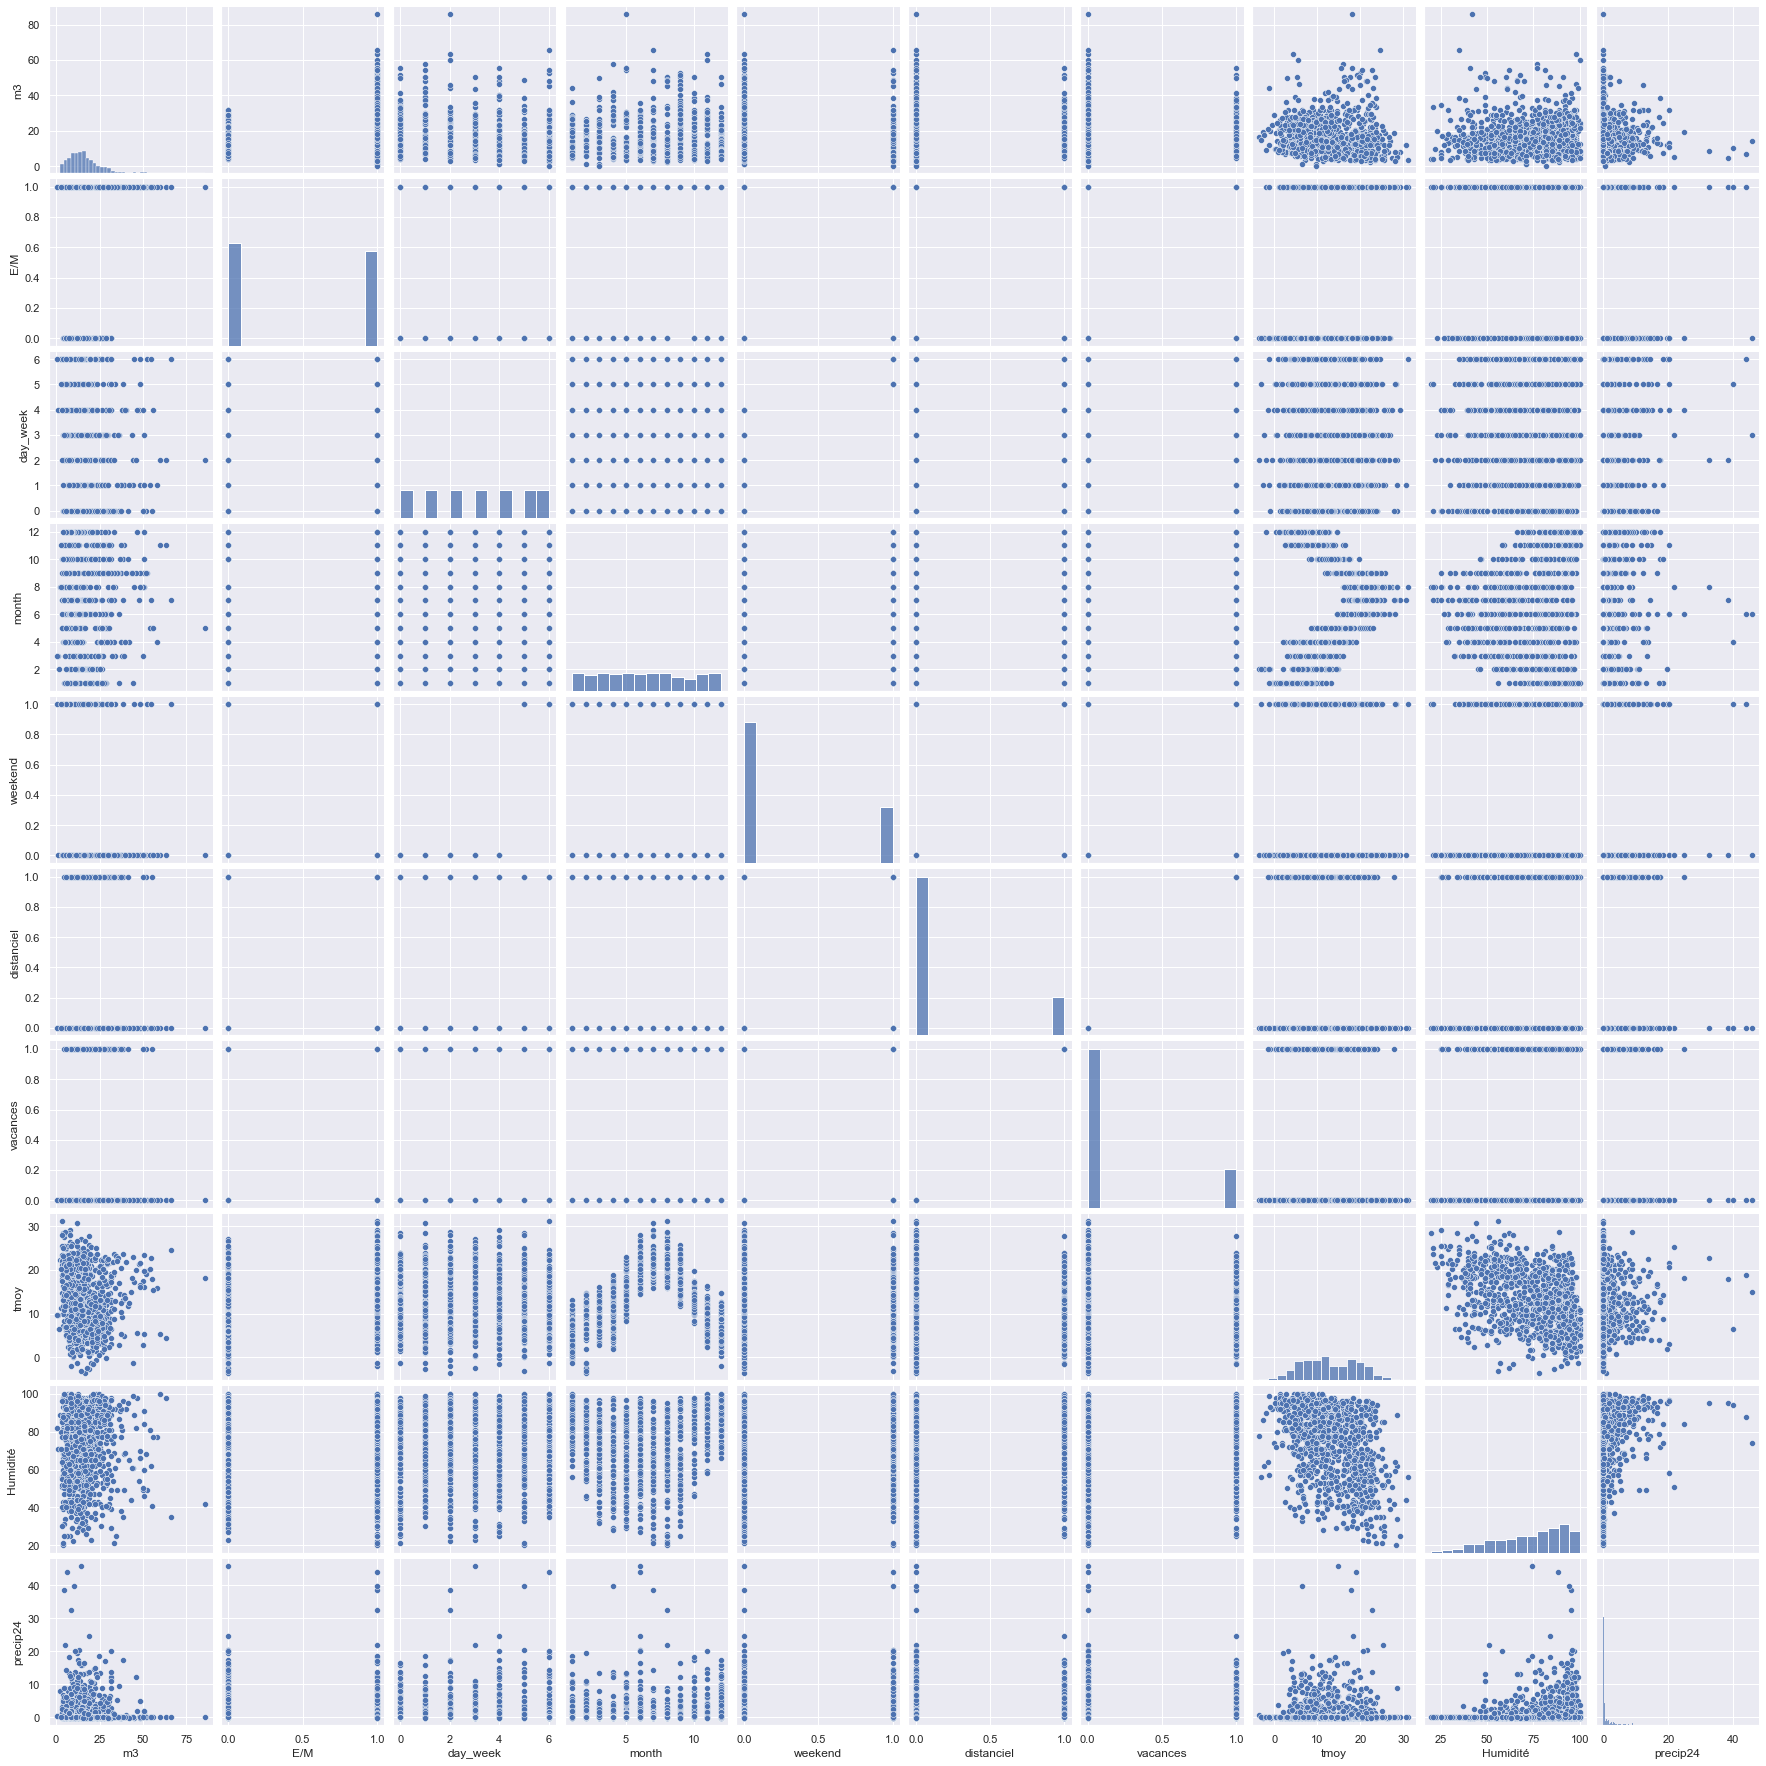

In [52]:
sns.set()
sns.pairplot(train_eau, height = 2.5)
plt.show()

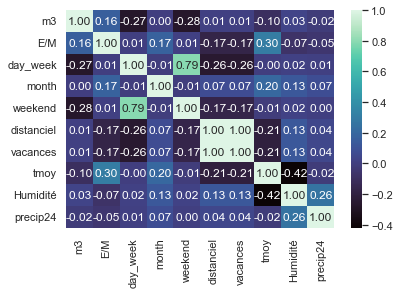

In [53]:
corrmat = train_eau.corr()

sns.heatmap(corrmat, cmap="mako", annot=True,fmt='.2f')

plt.show()

## Électricité <a class="anchor" id="Elec_feat"></a>

In [54]:
train_elec = elec_ESIEE.copy()
train_elec.head(10)

kW  day_week  month
datetime                            
2016-12-05  88082.0         0     12
2016-12-06  88163.0         1     12
2016-12-07  86948.0         2     12
2016-12-08  86602.0         3     12
2016-12-09  85669.0         4     12
2016-12-10  60099.0         5     12
2016-12-11  51642.0         6     12
2016-12-12  86816.0         0     12
2016-12-13  85411.0         1     12
2016-12-14  83271.0         2     12

In [55]:
conditions_weekend = ((train_elec['day_week'] == 5) | (train_elec['day_week'] == 6))


conditions_distanciel = (((train_elec.index >= '2022-09') & (train_elec['day_week'] == 2)) #E5
                          |((train_elec.index < '2022-09') & (train_elec.index >= '2021-09') & (train_elec['day_week'] == 0)) #E4
                          |((train_elec.index < '2021-07') & (train_elec.index >= '2021-02') & ((train_elec['day_week'] == 0)|(train_elec['day_week'] == 4))) #E3 Reprise
                          |((train_elec.index < '2021-02') & (train_elec.index >= '2020-11')) #E3 Full distanciel
                          |((train_elec.index < '2020-11') & (train_elec.index >= '2020-09') & ((train_elec['day_week'] == 0)|(train_elec['day_week'] == 4))) #E3 P1           
                        )

conditions_vacances = ((train_elec.index.month >= 7) & (train_elec.index.month < 9))

train_elec['weekend'] = np.where(conditions_weekend, 1, 0)
train_elec['distanciel'] = np.where(conditions_distanciel, 1 , 0)
train_elec['vacances'] = np.where(conditions_distanciel, 1 , 0)

train_elec = train_elec.join(temp)

train_elec = train_elec.join(meteo[['Humidité','precip24']])

train_elec.head(10)

kW  day_week  month  weekend  distanciel  vacances  tmoy  \
datetime                                                                    
2016-12-05  88082.0         0     12        0           0         0   NaN   
2016-12-06  88163.0         1     12        0           0         0   NaN   
2016-12-07  86948.0         2     12        0           0         0   NaN   
2016-12-08  86602.0         3     12        0           0         0   NaN   
2016-12-09  85669.0         4     12        0           0         0   NaN   
2016-12-10  60099.0         5     12        1           0         0   NaN   
2016-12-11  51642.0         6     12        1           0         0   NaN   
2016-12-12  86816.0         0     12        0           0         0   NaN   
2016-12-13  85411.0         1     12        0           0         0   NaN   
2016-12-14  83271.0         2     12        0           0         0   NaN   

            Humidité  precip24  
datetime                        
2016-12-05      86.0       0.0  
2016-12-06      94.0       0.0  
2016-12-07      97.0       0.0  
2016-12-08      77.0       0.0  
2016-12-09      79.0       0.0  
2016-12-10     100.0       0.0  
2016-12-11     100.0       0.0  
2016-12-12      99.0      -0.1  
2016-12-13      80.0       1.0  
2016-12-14      94.0       0.0

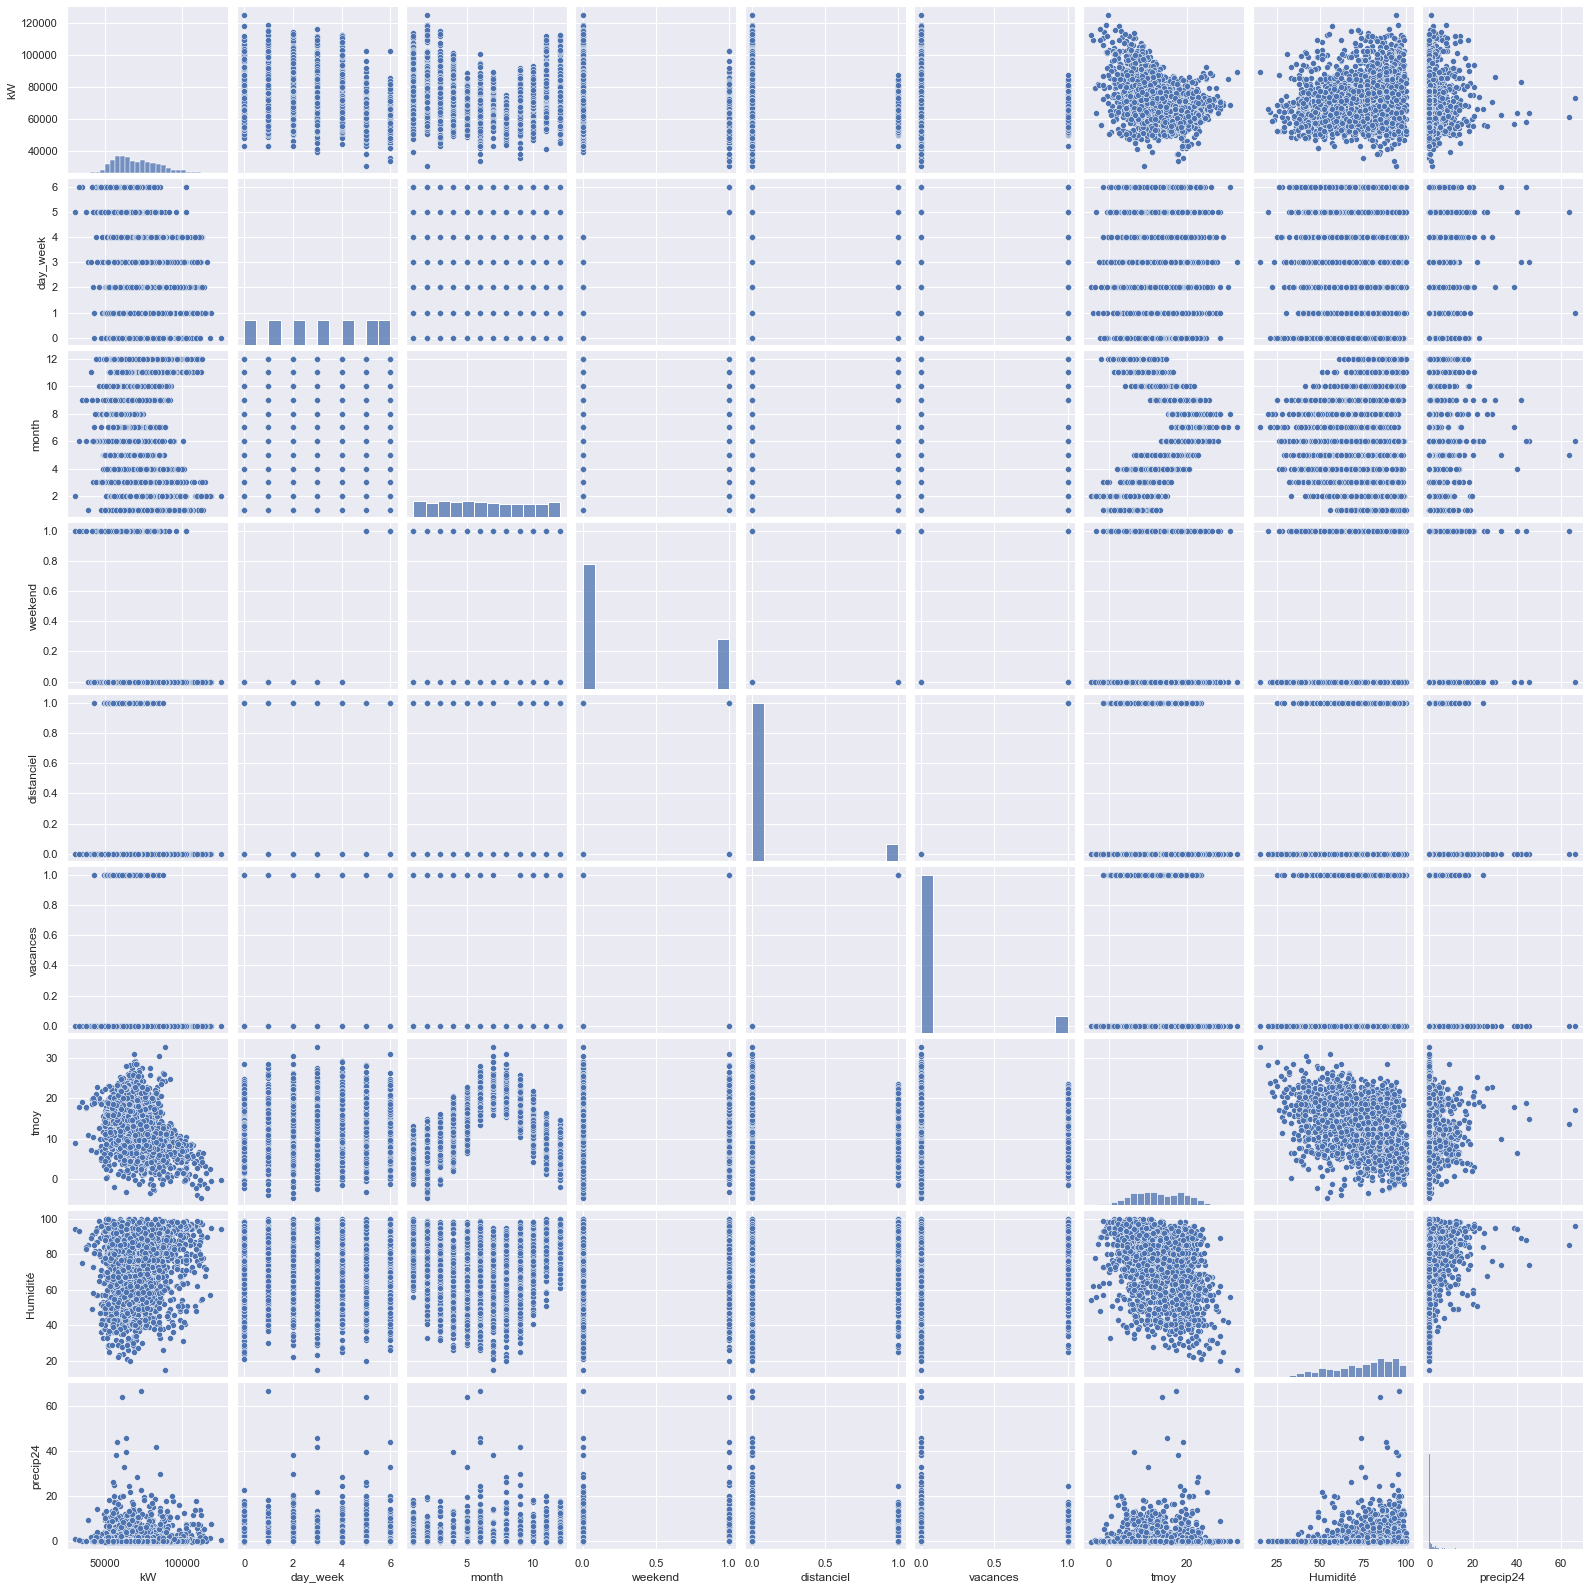

In [56]:
sns.set()
sns.pairplot(train_elec, height = 2.5)
plt.show()

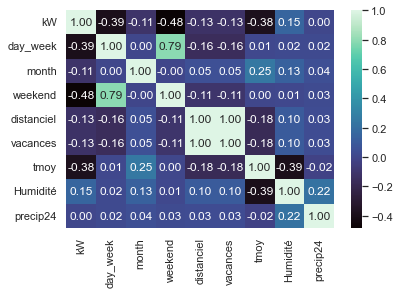

In [57]:
corrmat = train_elec.corr()

sns.heatmap(corrmat, cmap="mako", annot=True,fmt='.2f')

plt.show()

## GAZ <a class="anchor" id="Gaz_feat"></a>

In [58]:
train_gaz = gaz_ESIEE.copy()
train_gaz.head(10)

kWh  E/M  day_week  month
2018-06-01  2649.0  0.0         4      6
2018-06-02  2649.0  0.0         5      6
2018-06-03  2649.0  0.0         6      6
2018-06-04  2649.0  0.0         0      6
2018-06-05  2649.0  0.0         1      6
2018-06-06  2649.0  0.0         2      6
2018-06-07  2649.0  0.0         3      6
2018-06-08  2649.0  0.0         4      6
2018-06-09  2649.0  0.0         5      6
2018-06-10  2649.0  0.0         6      6

In [59]:
conditions_weekend = ((train_gaz['day_week'] == 5) | (train_gaz['day_week'] == 6))


conditions_distanciel = (((train_gaz.index >= '2022-09') & (train_gaz['day_week'] == 2)) #E5
                          |((train_gaz.index < '2022-09') & (train_gaz.index >= '2021-09') & (train_gaz['day_week'] == 0)) #E4
                          |((train_gaz.index < '2021-07') & (train_gaz.index >= '2021-02') & ((train_gaz['day_week'] == 0)|(train_gaz['day_week'] == 4))) #E3 Reprise
                          |((train_gaz.index < '2021-02') & (train_gaz.index >= '2020-11')) #E3 Full distanciel
                          |((train_gaz.index < '2020-11') & (train_gaz.index >= '2020-09') & ((train_gaz['day_week'] == 0)|(train_gaz['day_week'] == 4))) #E3 P1           
                        )

conditions_vacances = ((train_gaz.index.month >= 7) & (train_gaz.index.month < 9))

train_gaz['weekend'] = np.where(conditions_weekend, 1, 0)
train_gaz['distanciel'] = np.where(conditions_distanciel, 1 , 0)
train_gaz['vacances'] = np.where(conditions_distanciel, 1 , 0)

train_gaz = train_gaz.join(temp)


train_gaz = train_gaz.join(meteo[['Humidité','precip24']])

train_gaz.head(10)

kWh  E/M  day_week  month  weekend  distanciel  vacances  \
2018-06-01  2649.0  0.0         4      6        0           0         0   
2018-06-02  2649.0  0.0         5      6        1           0         0   
2018-06-03  2649.0  0.0         6      6        1           0         0   
2018-06-04  2649.0  0.0         0      6        0           0         0   
2018-06-05  2649.0  0.0         1      6        0           0         0   
2018-06-06  2649.0  0.0         2      6        0           0         0   
2018-06-07  2649.0  0.0         3      6        0           0         0   
2018-06-08  2649.0  0.0         4      6        0           0         0   
2018-06-09  2649.0  0.0         5      6        1           0         0   
2018-06-10  2649.0  0.0         6      6        1           0         0   

             tmoy  Humidité  precip24  
2018-06-01  18.85      92.0       2.4  
2018-06-02  19.90      46.0       2.4  
2018-06-03  20.30      89.0       0.0  
2018-06-04  21.80      81.0      -0.1  
2018-06-05  19.20      76.0       8.2  
2018-06-06  18.65      93.0      20.5  
2018-06-07  20.90      63.0      11.9  
2018-06-08  19.95      93.0       0.2  
2018-06-09  19.10      92.0       0.0  
2018-06-10  19.65      95.0       NaN

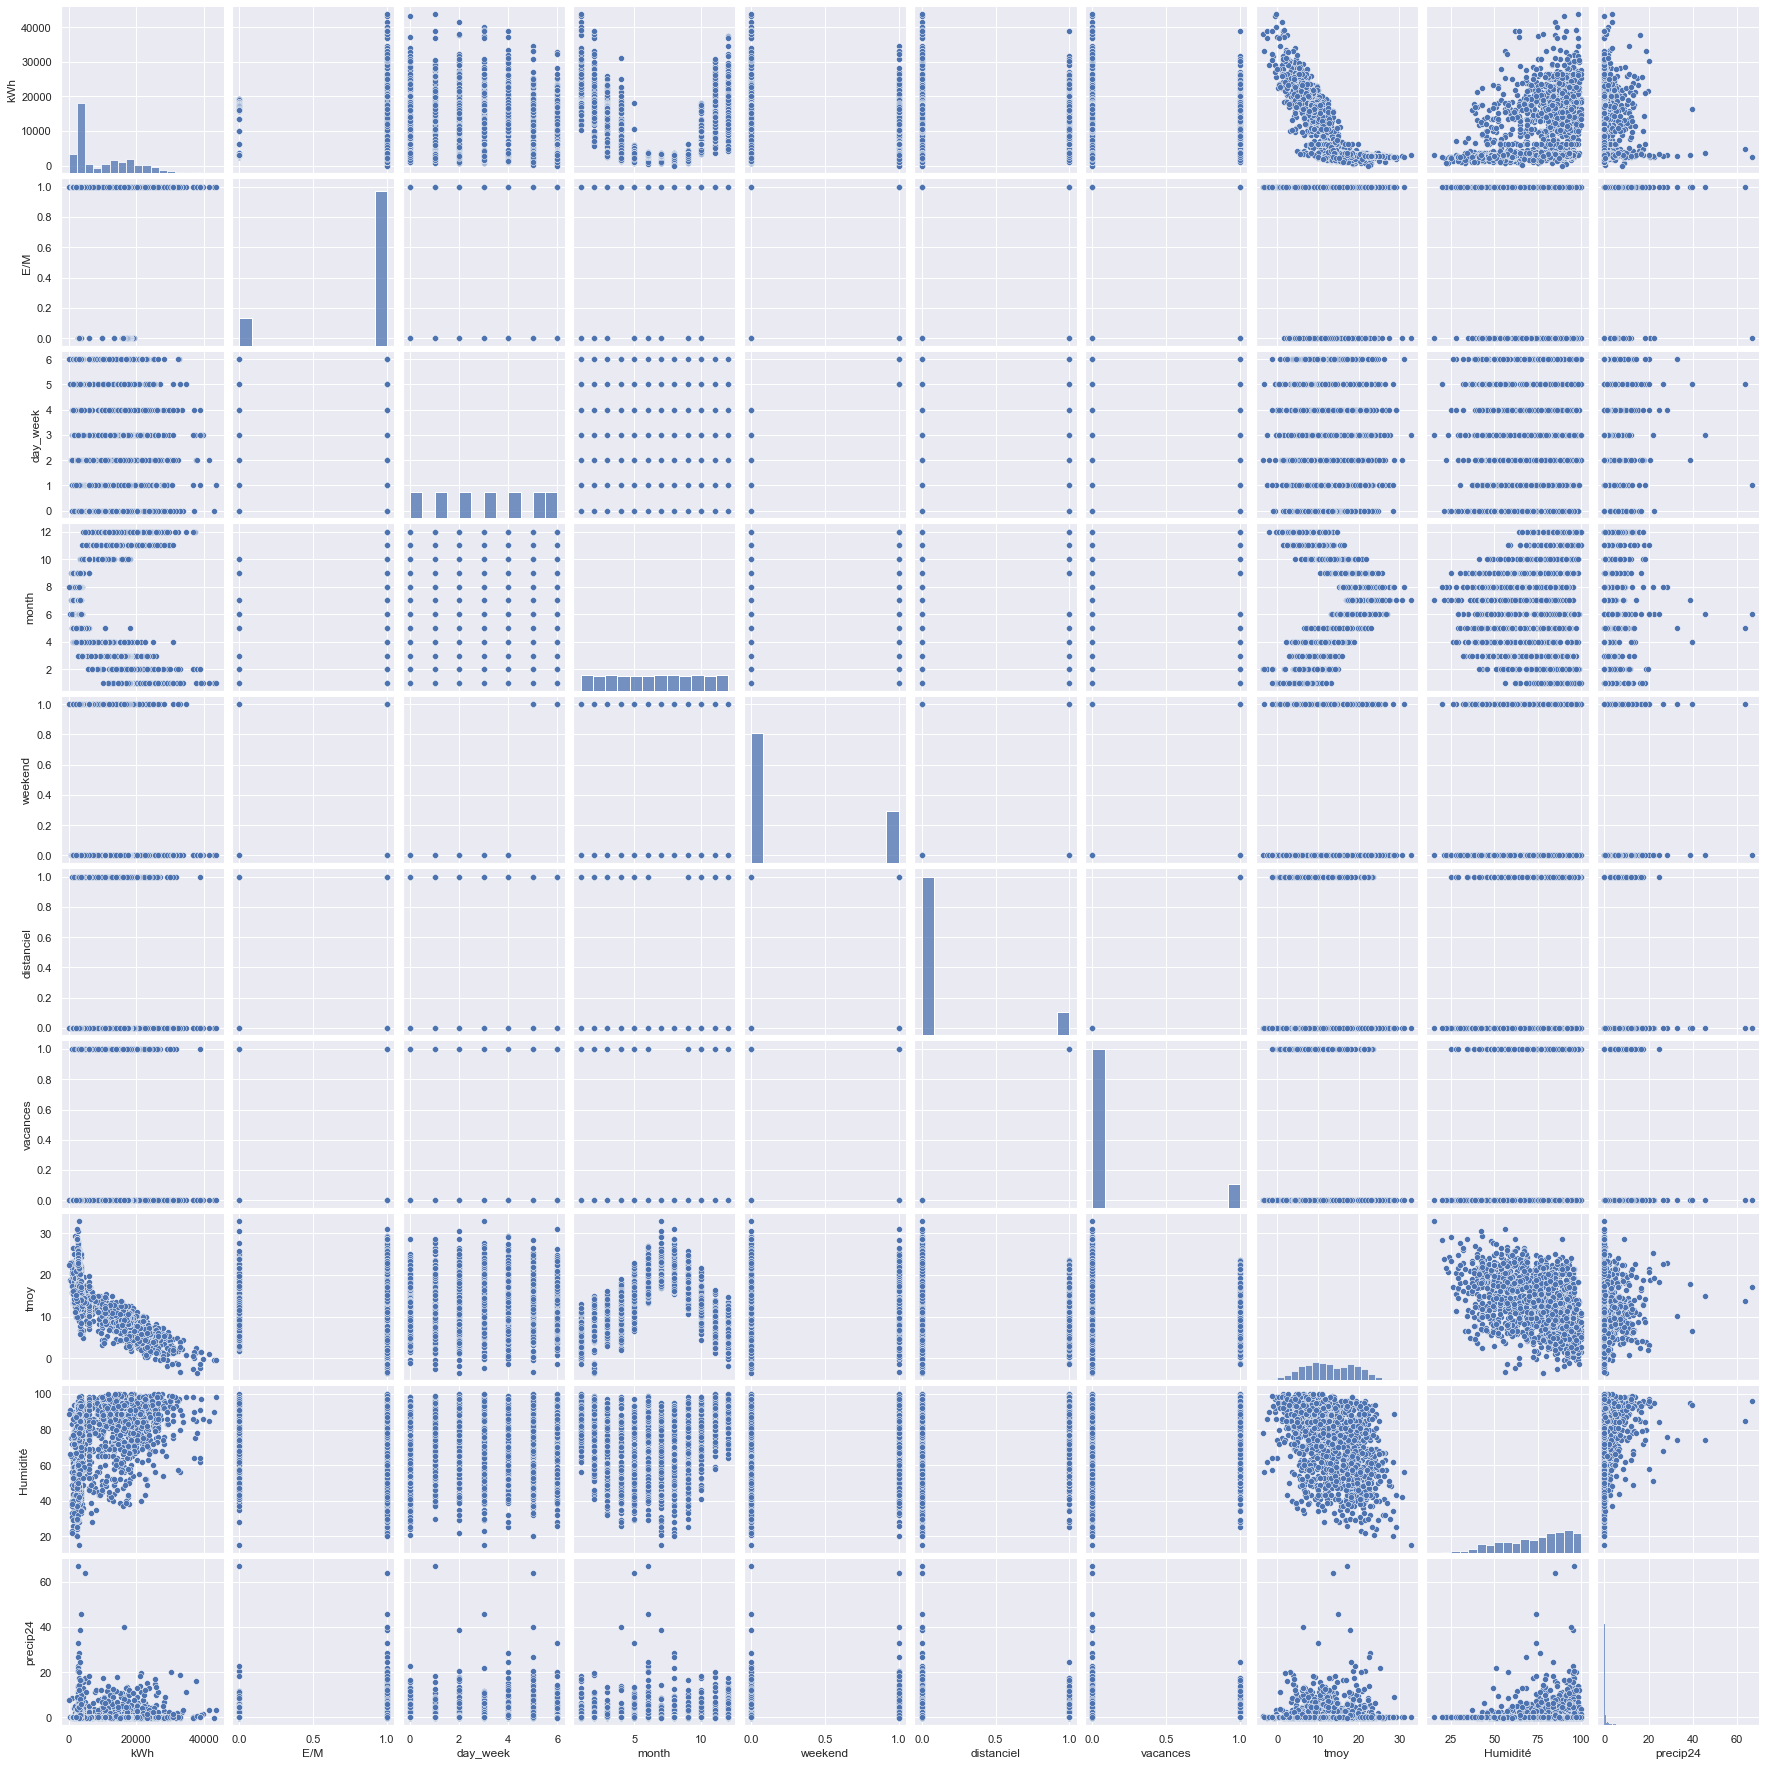

In [60]:
sns.set()
sns.pairplot(train_gaz, height = 2.5)
plt.show()

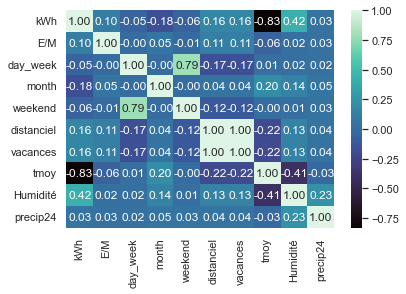

In [61]:
corrmat = train_gaz.corr()

sns.heatmap(corrmat, cmap="mako", annot=True,fmt='.2f')

plt.show()

# Création des modèles <a class="anchor" id="model"></a>

## Elec <a class="anchor" id="Elec_model"></a>

### NAIVE ELEC <a class="anchor" id="Elec_naive"></a>

In [62]:
def plot_ys(*args, **kwargs):
    # restore previous behaviour (jfb)
    nb_series=len(args)
    plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

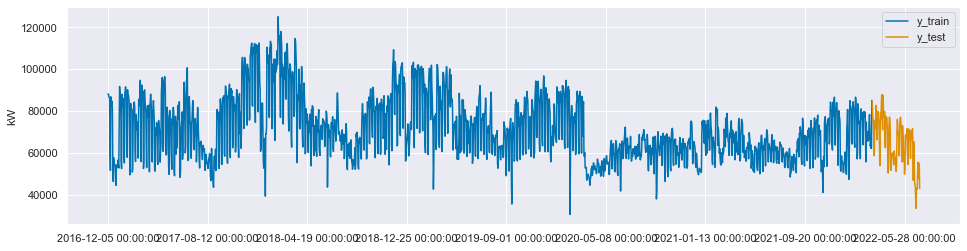

In [63]:
y = pd.Series(data=train_elec['kW'])
y_train, y_test = temporal_train_test_split(y, test_size=120)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

In [64]:
fh = np.arange(1,len(y_test)+1) 
fh

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

0.2365779162258532

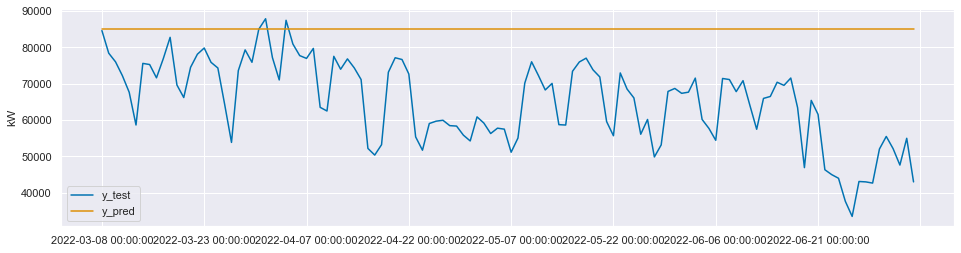

In [65]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.1500183937688451

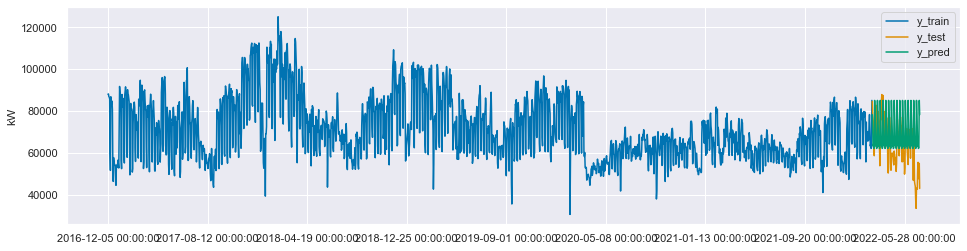

In [66]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

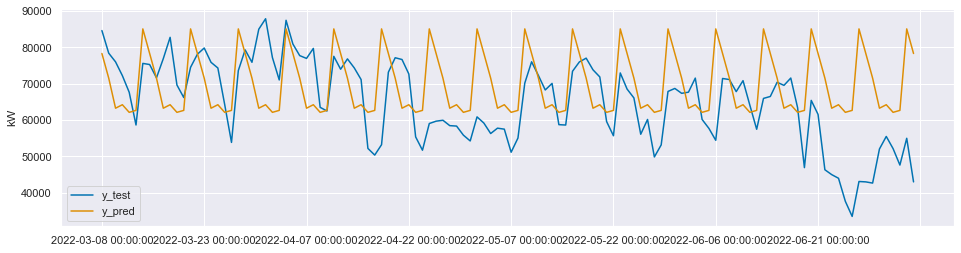

In [67]:
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"])


### DEEP ELEC <a class="anchor" id="Elec_deep"></a>


In [68]:
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

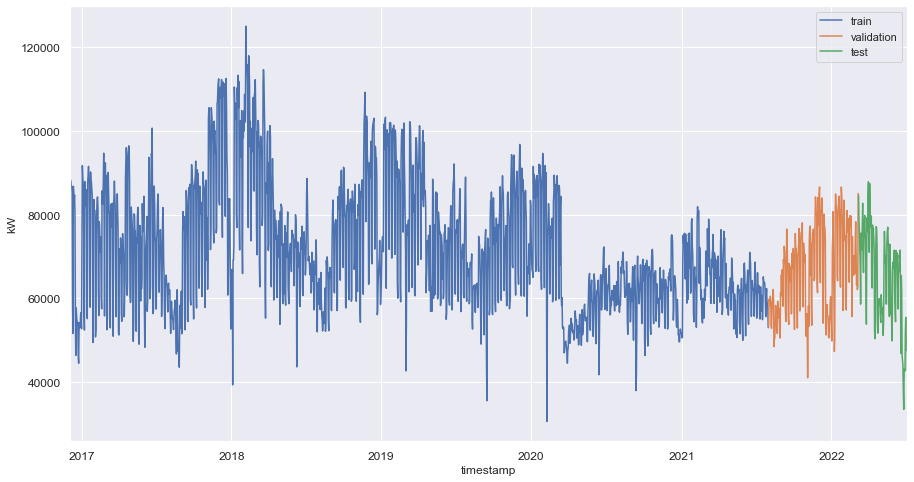

In [69]:
T=3
HORIZON=1
valid_start_dt = '2021-08-01'
test_start_dt = '2022-03-08'

train_elec[train_elec.index < valid_start_dt][['kW']].rename(columns={'kW':'train'}) \
    .join(train_elec[(train_elec.index >=valid_start_dt) & (train_elec.index < test_start_dt)][['kW']] \
          .rename(columns={'kW':'validation'}), how='outer') \
    .join(train_elec[test_start_dt:][['kW']].rename(columns={'kW':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('kW', fontsize=12)
plt.show()

In [70]:
# Create training dataset with load and temp features
train = train_elec.copy()[train_elec.index < valid_start_dt][['kW', 'tmoy','weekend']]

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['kW']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['kW', 'tmoy','weekend']] = X_scaler.fit_transform(train)

In [71]:
tensor_structure = {'X':(range(-T+1, 1), ['kW', 'tmoy','weekend'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='kW',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
train_inputs.dataframe.head(5)

tensor        target         X                                          \
feature            y        kW                          tmoy             
time step        t+1       t-2       t-1         t       t-2       t-1   
datetime                                                                 
2018-01-03  0.092567  0.261644  0.384558  0.351817  0.342246  0.391711   
2018-01-04  0.407841  0.384558  0.351817  0.092567  0.391711  0.363636   
2018-01-05  0.408137  0.351817  0.092567  0.407841  0.363636  0.417112   
2018-01-06  0.444141  0.092567  0.407841  0.408137  0.417112  0.375668   
2018-01-07  0.846134  0.407841  0.408137  0.444141  0.375668  0.283422   

tensor                                  
feature              weekend            
time step          t     t-2  t-1    t  
datetime                                
2018-01-03  0.363636     0.0  0.0  0.0  
2018-01-04  0.417112     0.0  0.0  0.0  
2018-01-05  0.375668     0.0  0.0  0.0  
2018-01-06  0.283422     0.0  0.0  1.0  
2018-01-07  0.290107     0.0  1.0  1.0

In [72]:
X_train = train_inputs['X']
y_train = train_inputs['target']

In [73]:
X_train.shape

(1305, 3, 3)

In [74]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = train_elec.copy()[(train_elec.index >=look_back_dt) & (train_elec.index < test_start_dt)][['kW', 'tmoy','weekend']]
valid[['kW', 'tmoy','weekend']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(dataset=valid,
                            target='kW',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

In [75]:
y_valid.shape

(218, 1)

In [76]:
FIRST_LAYER_LATENT_DIM = 25 # number of units in the 1st RNN layer
SECOND_LAYER_LATENT_DIM = 15 #number of units in the 2nd RNN layer
THIRD_LAYER_LATENT_DIM = 10
BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [77]:
model = Sequential()
model.add(GRU(FIRST_LAYER_LATENT_DIM,input_shape=(T,3),return_sequences=True))
model.add(GRU(SECOND_LAYER_LATENT_DIM,input_shape=(T,3),return_sequences=True))
model.add(GRU(THIRD_LAYER_LATENT_DIM,input_shape=(T,3)))
model.add(Dense(HORIZON))

In [78]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 25)             2250      
                                                                 
 gru_1 (GRU)                 (None, 3, 15)             1890      
                                                                 
 gru_2 (GRU)                 (None, 10)                810       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [79]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=0)

In [80]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = train_elec.copy()[test_start_dt:][['kW', 'tmoy','weekend']]
test[['kW', 'tmoy','weekend']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(dataset=test,
                            target='kW',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
X_test = test_inputs['X']
y_test = test_inputs['target']

In [81]:
predictions = model.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

4/4 [==============================] - 2s 4ms/step


timestamp    h    prediction   actual
0 2022-03-10  t+1  76971.299623  72221.0
1 2022-03-11  t+1  73228.009259  67659.0
2 2022-03-12  t+1  71999.906877  58652.0
3 2022-03-13  t+1  74347.691575  75587.0
4 2022-03-14  t+1  83121.850272  75274.0

In [82]:
smape_loss(eval_df['prediction'], eval_df['actual'])

0.10355535048499628

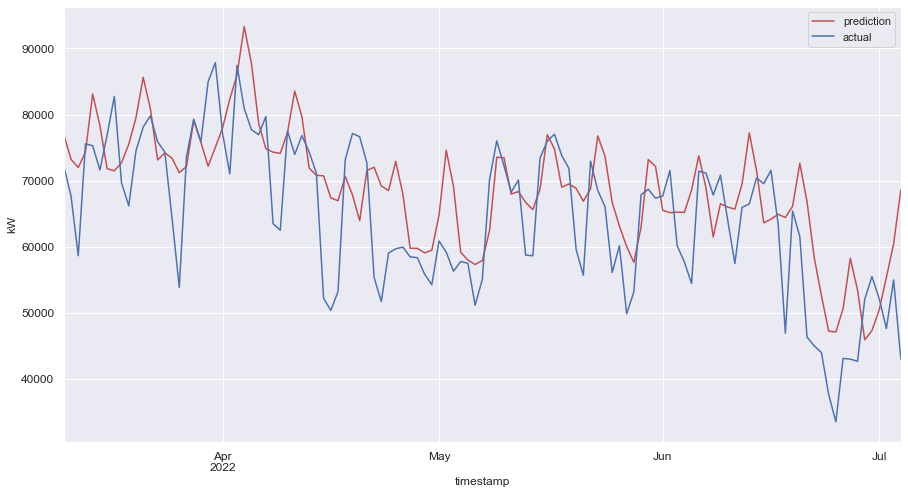

In [83]:
eval_df.plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('kW', fontsize=12)
plt.show()

### SARIMAX ELEC REGRESSION DYNAMIQUE <a class="anchor" id="Elec_stat"></a>

(P,D,Q,M) Order
The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity:

- D indicates the integration order of the seasonal process (the number of transformation needed to make stationary the time series)
- P indicates the Auto Regressive order for the seasonal component
- Q indicated the Moving Average order for the seasonal component
- M indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

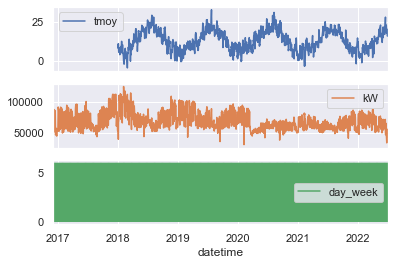

In [271]:
train_elec[['tmoy','kW','day_week']].plot(subplots=True)

In [272]:
train_elec[train_elec['tmoy'].notna()]

kW  day_week  month  weekend  distanciel  vacances   tmoy  \
datetime                                                                     
2018-01-01  55324.0         0      1        0           0         0   8.20   
2018-01-02  66928.0         1      1        0           0         0  10.05   
2018-01-03  63837.0         2      1        0           0         0   9.00   
2018-01-04  39362.0         3      1        0           0         0  11.00   
2018-01-05  69126.0         4      1        0           0         0   9.45   
...             ...       ...    ...      ...         ...       ...    ...   
2022-07-01  55503.0         4      7        0           0         0  16.00   
2022-07-02  52158.0         5      7        1           0         0  18.85   
2022-07-03  47634.0         6      7        1           0         0  18.60   
2022-07-04  54996.0         0      7        0           1         1  18.60   
2022-07-05  43009.0         1      7        0           0         0  18.75   

            Humidité  precip24  
datetime                        
2018-01-01      81.0       1.8  
2018-01-02      92.0       1.0  
2018-01-03      61.0       8.3  
2018-01-04      85.0       9.6  
2018-01-05      88.0       9.5  
...              ...       ...  
2022-07-01      41.0      -0.1  
2022-07-02      52.0       0.2  
2022-07-03      41.0       0.0  
2022-07-04      39.0       0.0  
2022-07-05      81.0       0.0  

[1647 rows x 9 columns]

In [386]:
adf, pa, *_  = adfuller(train_elec['kW'].dropna())
print("p-value adf : ", pa)

p-value adf :  0.002014000551443233


In [387]:
xd =  train_elec['kW'].diff(1)
adf, pa, *_  = adfuller(xd.dropna())
print("p-value adf : ", pa)

p-value adf :  4.188033532733263e-23


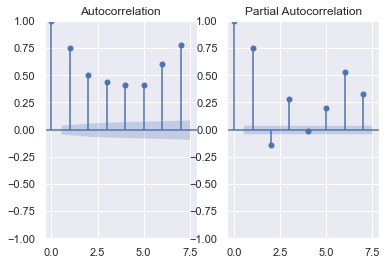

In [388]:
fig, ax = plt.subplots(1,2)
plot_acf(train_elec['kW'].dropna(), ax=ax[0],lags=7) 
plot_pacf(train_elec['kW'].dropna(), ax=ax[1],lags=7);

<AxesSubplot:xlabel='datetime'>

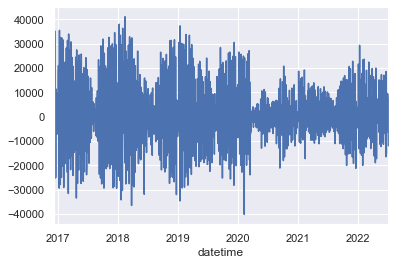

In [389]:
xd.plot()

In [390]:
usable = train_elec.loc[train_elec.index >= '2018-01-01']
train, test = temporal_train_test_split(usable, test_size=120)

In [546]:
endog = train['kW']
exog = pd.DataFrame(index=train.index, columns=['tmoy','weekend'])
exog['tmoy']=train['tmoy']
exog['weekend'] = train['weekend']

mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,4), seasonal_order=(7,0,0,7))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 kW   No. Observations:                 1527
Model:             SARIMAX(1, 0, 4)x(7, 0, [], 7)   Log Likelihood              -16153.205
Date:                            Sun, 06 Nov 2022   AIC                          32336.410
Time:                                    00:07:52   BIC                          32416.376
Sample:                                01-01-2018   HQIC                         32366.173
                                     - 03-07-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmoy       -1070.0721    304.038     -3.520      0.000   -1665.975    -474.169
weekend     8539.6413      0.117   

In [547]:
exog_future = pd.DataFrame(index=test.index, columns=['tmoy','weekend'])
exog_future['tmoy'] = test['tmoy']
exog_future['weekend'] = test['weekend']

In [548]:
predictions = res.forecast(120, exog=exog_future)

In [549]:
predictions

2022-03-08    81782.129191
2022-03-09    74809.824951
2022-03-10    69702.873778
2022-03-11    69140.227133
2022-03-12    62278.662206
                  ...     
2022-07-01    57912.673430
2022-07-02    47863.265103
2022-07-03    44910.843615
2022-07-04    59566.375413
2022-07-05    59198.103560
Freq: D, Name: predicted_mean, Length: 120, dtype: float64

In [550]:
predictions.index.name = 'Date'

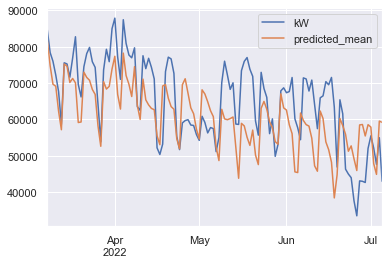

In [551]:
out = pd.concat([usable.loc[test.index,'kW'], predictions],axis=1).plot()

In [552]:
smape_loss(usable.loc[test.index,'kW'], predictions)

0.12875122383568394

## Eau <a class="anchor" id="Eau_model"></a>

### NAIVE EAU <a class="anchor" id="Eau_naive"></a>

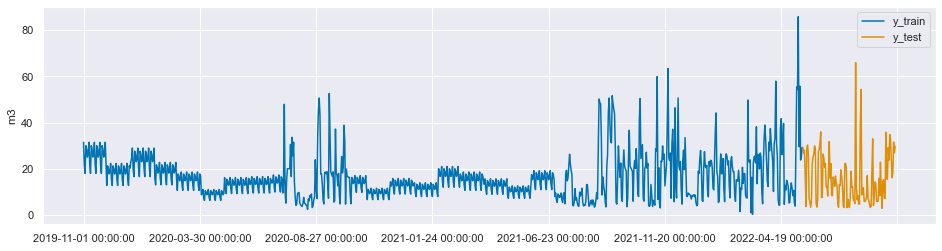

In [553]:
y = pd.Series(data=train_eau['m3'])
y_train, y_test = temporal_train_test_split(y, test_size=120)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

In [554]:
fh = np.arange(1,len(y_test)+1) 
fh

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

0.518376652986776

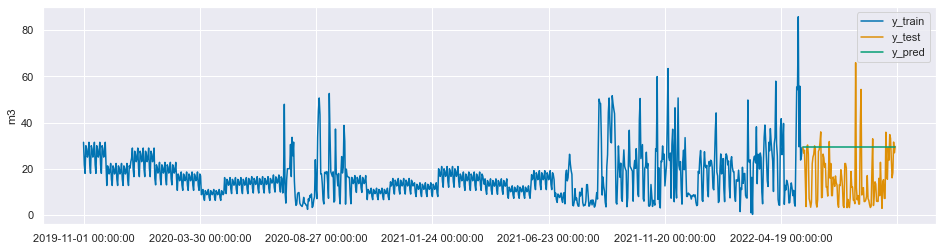

In [555]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

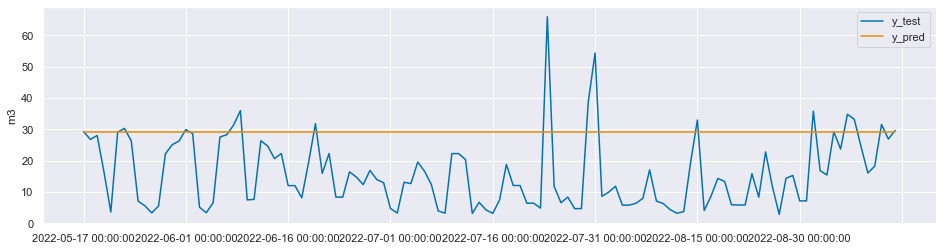

In [556]:
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"])

0.6222716904481097

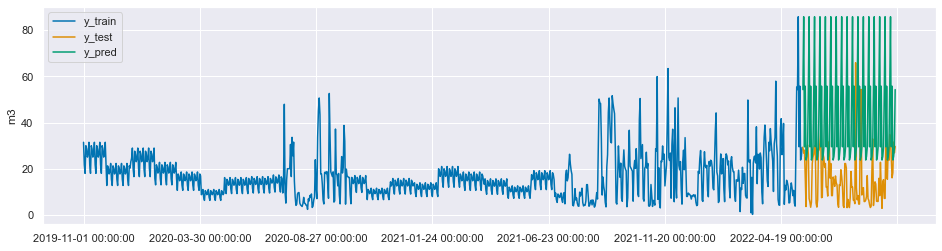

In [557]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

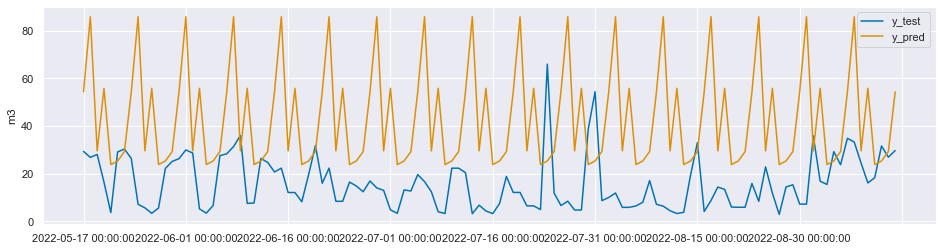

In [558]:
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"])

### DEEP EAU <a class="anchor" id="Eau_deep"></a>

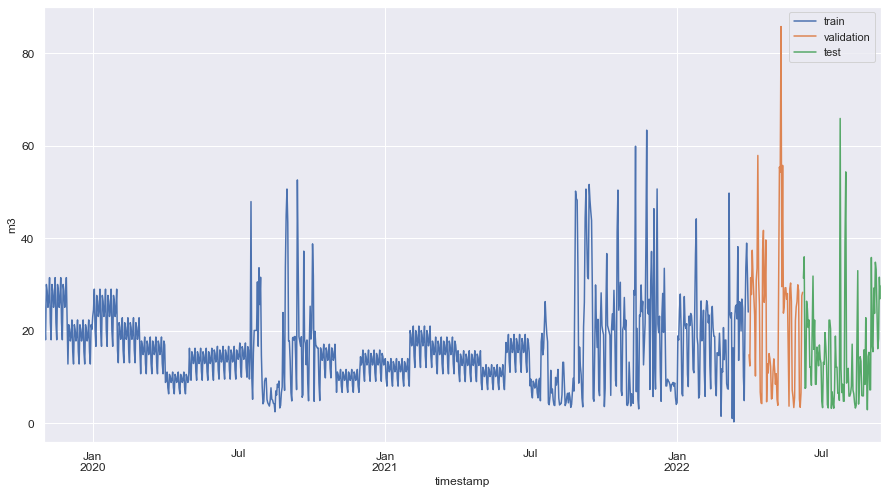

In [559]:
valid_start_dt = '2022-04-01'
test_start_dt = '2022-06-08'

train_eau[train_eau.index < valid_start_dt][['m3']].rename(columns={'m3':'train'}) \
    .join(train_eau[(train_eau.index >=valid_start_dt) & (train_eau.index < test_start_dt)][['m3']] \
          .rename(columns={'m3':'validation'}), how='outer') \
    .join(train_eau[test_start_dt:][['m3']].rename(columns={'m3':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('m3', fontsize=12)
plt.show()

In [560]:
T=3
HORIZON=1

In [561]:
# Create training dataset with load and temp features
train = train_eau.copy()[train_eau.index < valid_start_dt][['m3', 'day_week']]

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['m3']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['m3', 'day_week']] = X_scaler.fit_transform(train)

In [562]:
tensor_structure = {'X':(range(-T+1, 1), ['m3', 'day_week'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='m3',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
train_inputs.dataframe.head(5)

tensor        target         X                                          \
feature            y        m3                      day_week             
time step        t+1       t-2       t-1         t       t-2       t-1   
2019-11-03  0.470998  0.494453  0.340729  0.281458  0.666667  0.833333   
2019-11-04  0.448970  0.340729  0.281458  0.470998  0.833333  1.000000   
2019-11-05  0.392710  0.281458  0.470998  0.448970  1.000000  0.000000   
2019-11-06  0.418067  0.470998  0.448970  0.392710  0.000000  0.166667   
2019-11-07  0.494453  0.448970  0.392710  0.418067  0.166667  0.333333   

tensor                
feature               
time step          t  
2019-11-03  1.000000  
2019-11-04  0.000000  
2019-11-05  0.166667  
2019-11-06  0.333333  
2019-11-07  0.500000

In [563]:
X_train = train_inputs['X']
y_train = train_inputs['target']

In [564]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = train_eau.copy()[(train_eau.index >=look_back_dt) & (train_eau.index < test_start_dt)][['m3', 'day_week']]
valid[['m3', 'day_week']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(dataset=valid,
                            target='m3',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

In [565]:
FIRST_LAYER_LATENT_DIM = 15 # number of units in the 1st RNN layer
SECOND_LAYER_LATENT_DIM = 10 #number of units in the 2nd RNN layer
BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 20 # maximum number of times the training algorithm will cycle through all samples

In [566]:
model = Sequential()
model.add(GRU(FIRST_LAYER_LATENT_DIM,input_shape=(T,2),return_sequences=True))
model.add(GRU(SECOND_LAYER_LATENT_DIM,input_shape=(T,2)))
model.add(Dense(HORIZON))

model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 3, 15)             855       
                                                                 
 gru_22 (GRU)                (None, 10)                810       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,676
Trainable params: 1,676
Non-trainable params: 0
_________________________________________________________________


In [567]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=0)


In [568]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = train_eau.copy()[test_start_dt:][['m3', 'day_week']]
test[['m3','day_week']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(dataset=test,
                            target='m3',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
X_test = test_inputs['X']
y_test = test_inputs['target']

In [569]:
predictions = model.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

3/3 [==============================] - 1s 2ms/step


timestamp    h  prediction  actual
0 2022-06-10  t+1   20.725654    7.67
1 2022-06-11  t+1   16.014758   26.36
2 2022-06-12  t+1   18.816479   24.69
3 2022-06-13  t+1   24.763927   20.68
4 2022-06-14  t+1   23.645403   22.30

In [570]:
smape_loss(eval_df['prediction'], eval_df['actual'])

0.5389742893190667

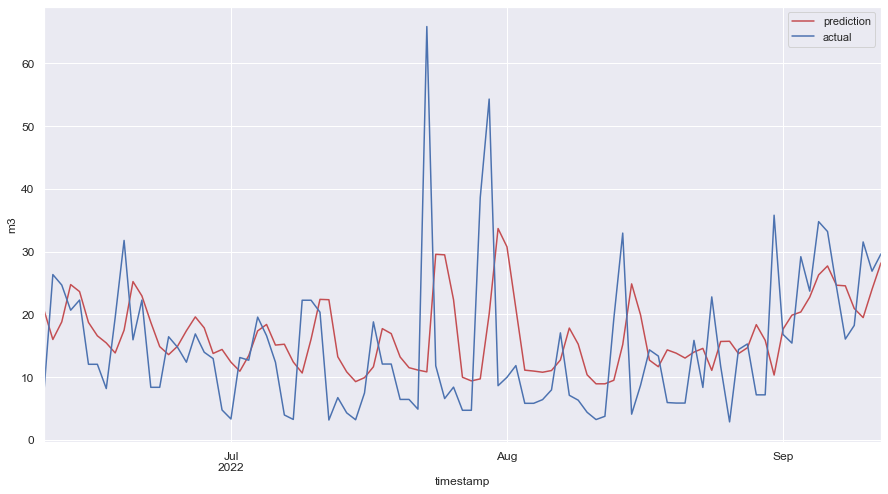

In [571]:
eval_df.plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('m3', fontsize=12)
plt.show()

### SARIMAX EAU REGRESSION DYNAMIQUE <a class="anchor" id="Eau_stat"></a>

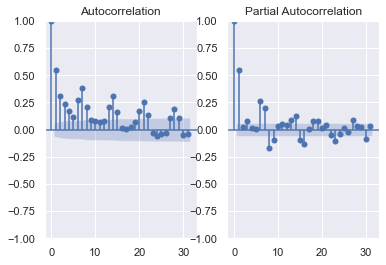

In [591]:
fig, ax = plt.subplots(1,2)
plot_acf(train_eau['m3'].dropna(), ax=ax[0]) 
plot_pacf(train_eau['m3'].dropna(), ax=ax[1]);

In [572]:
adf, pa, *_  = adfuller(train_eau['m3'].dropna())
print("p-value adf : ", pa)

p-value adf :  9.036517425757427e-06


In [573]:
xd =  train_eau['m3'].diff(1)
adf, pa, *_  = adfuller(xd.dropna())
print("p-value adf : ", pa)

p-value adf :  3.265295192924982e-15


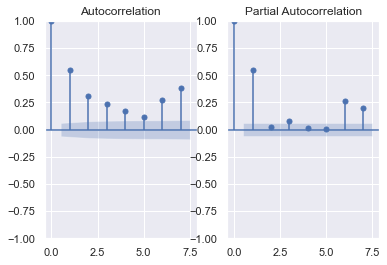

In [574]:
fig, ax = plt.subplots(1,2)
plot_acf(train_eau['m3'].dropna(), ax=ax[0],lags=7) 
plot_pacf(train_eau['m3'].dropna(), ax=ax[1],lags=7);

<AxesSubplot:>

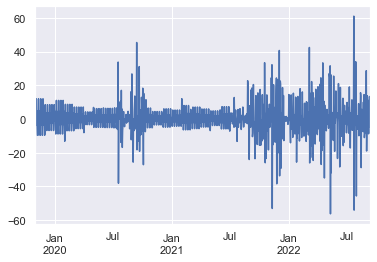

In [575]:
xd.plot()

In [576]:
train, test = temporal_train_test_split(train_eau, test_size=120)

In [592]:
endog = train['m3']
exog = train['day_week']

mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,2), seasonal_order=(7,0,2,7))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                m3   No. Observations:                  928
Model:             SARIMAX(1, 0, 2)x(7, 0, 2, 7)   Log Likelihood               -3089.499
Date:                           Sun, 06 Nov 2022   AIC                           6206.998
Time:                                   00:42:55   BIC                           6274.660
Sample:                               11-01-2019   HQIC                          6232.807
                                    - 05-16-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
day_week      -0.3328      1.280     -0.260      0.795      -2.842       2.177
ar.L1          0.7310      0.035     20.846

In [593]:
res.aicc

6207.457763596094

In [594]:
exog_future = pd.DataFrame(index=test.index, columns=['day_week'])
exog_future['day_week'] = test['day_week']


In [595]:
predictions = res.forecast(120, exog=exog_future)

In [596]:
predictions
predictions.index.name = 'Date'

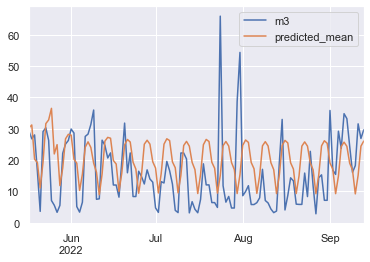

In [597]:
out = pd.concat([train_eau.loc[test.index,'m3'], predictions],axis=1).plot()

In [599]:
smape_loss(train_eau.loc[test.index,'m3'], predictions)

1.154285789624971

## Gaz <a class="anchor" id="Gaz_model"></a>

### NAIVE GAZ <a class="anchor" id="Gaz_naive"></a>

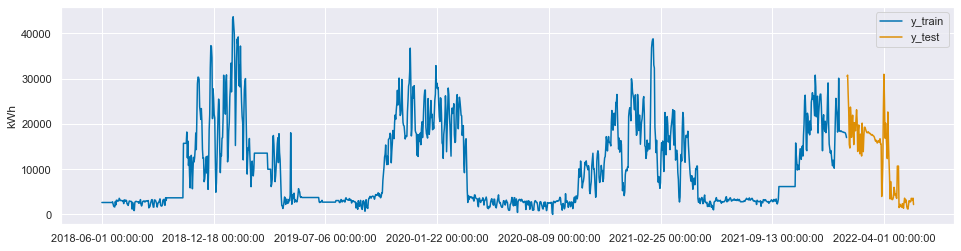

In [600]:
y = pd.Series(data=train_gaz.loc[train_gaz['kWh'].notna(),'kWh'])
y_train, y_test = temporal_train_test_split(y, test_size=120)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

In [601]:
fh = np.arange(1,len(y_test)+1) 
fh

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120])

0.39777594714813147

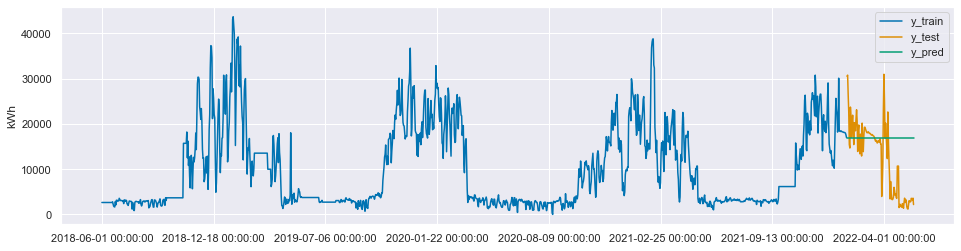

In [602]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

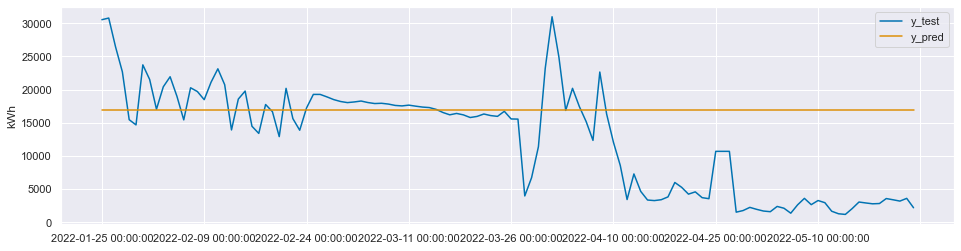

In [603]:
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"])

0.39594871925041325

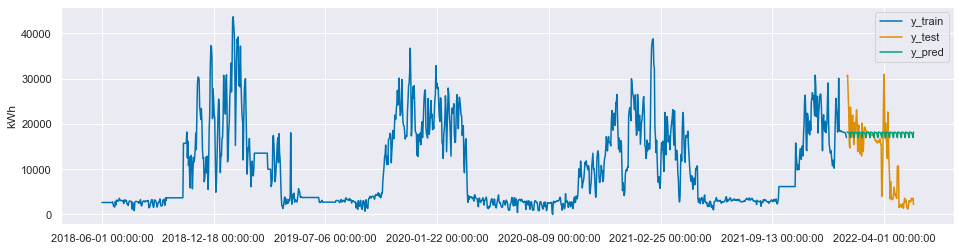

In [604]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

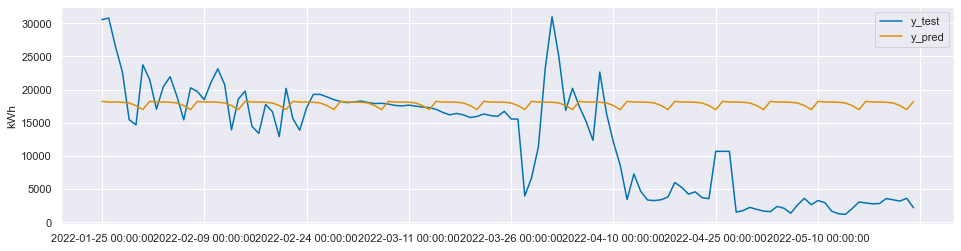

In [605]:
plot_ys(y_test, y_pred, labels=["y_test", "y_pred"])

### DEEP Gaz <a class="anchor" id="Gaz_deep"></a>

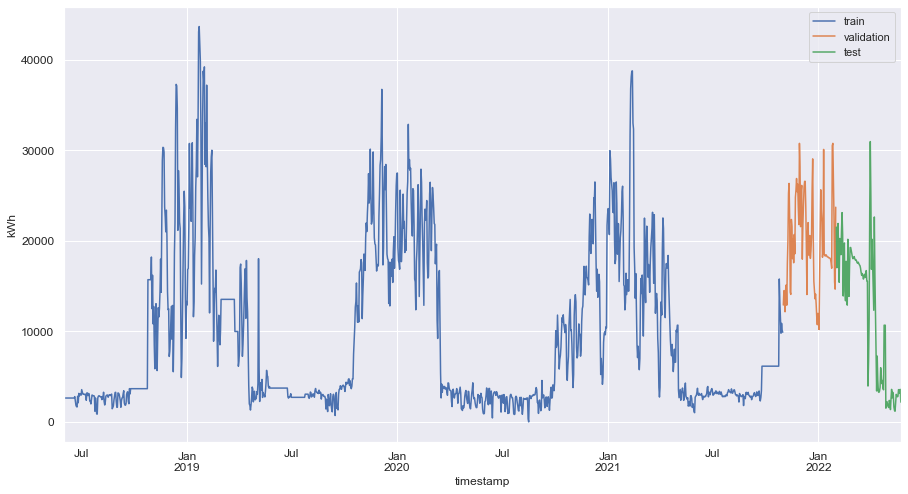

In [606]:
valid_start_dt = '2021-11-01'
test_start_dt = '2022-02-01'

train_gaz[train_gaz.index < valid_start_dt][['kWh']].rename(columns={'kWh':'train'}) \
    .join(train_gaz[(train_gaz.index >=valid_start_dt) & (train_gaz.index < test_start_dt)][['kWh']] \
          .rename(columns={'kWh':'validation'}), how='outer') \
    .join(train_gaz[test_start_dt:][['kWh']].rename(columns={'kWh':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.show()

In [607]:
T=10
HORIZON=1

In [608]:
# Create training dataset with load and temp features
train = train_gaz.copy()[train_gaz.index < valid_start_dt][['kWh', 'tmoy','Humidité']]

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['kWh']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['kWh', 'tmoy','Humidité']] = X_scaler.fit_transform(train)

In [609]:
tensor_structure = {'X':(range(-T+1, 1), ['kWh', 'tmoy','Humidité'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='kWh',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
train_inputs.dataframe.head(5)

tensor        target         X                                          \
feature            y       kWh                                           
time step        t+1       t-9       t-8       t-7       t-6       t-5   
2018-06-10  0.060335  0.060335  0.060335  0.060335  0.060335  0.060335   
2018-06-11  0.060335  0.060335  0.060335  0.060335  0.060335  0.060335   
2018-06-12  0.060335  0.060335  0.060335  0.060335  0.060335  0.060335   
2018-06-13  0.060335  0.060335  0.060335  0.060335  0.060335  0.060335   
2018-06-14  0.060335  0.060335  0.060335  0.060335  0.060335  0.060335   

tensor                                              ...                      \
feature                                             ...  Humidité             
time step        t-4       t-3       t-2       t-1  ...       t-9       t-8   
2018-06-10  0.060335  0.060335  0.060335  0.060335  ...  0.905882  0.364706   
2018-06-11  0.060335  0.060335  0.060335  0.060335  ...  0.364706  0.870588   
2018-06-12  0.060335  0.060335  0.060335  0.060335  ...  0.870588  0.776471   
2018-06-13  0.060335  0.060335  0.060335  0.060335  ...  0.776471  0.717647   
2018-06-14  0.060335  0.060335  0.060335  0.060335  ...  0.717647  0.917647   

tensor                                                                  \
feature                                                                  
time step        t-7       t-6       t-5       t-4       t-3       t-2   
2018-06-10  0.870588  0.776471  0.717647  0.917647  0.564706  0.917647   
2018-06-11  0.776471  0.717647  0.917647  0.564706  0.917647  0.905882   
2018-06-12  0.717647  0.917647  0.564706  0.917647  0.905882  0.941176   
2018-06-13  0.917647  0.564706  0.917647  0.905882  0.941176  0.941176   
2018-06-14  0.564706  0.917647  0.905882  0.941176  0.941176  0.952941   

tensor                          
feature                         
time step        t-1         t  
2018-06-10  0.905882  0.941176  
2018-06-11  0.941176  0.941176  
2018-06-12  0.941176  0.952941  
2018-06-13  0.952941  0.764706  
2018-06-14  0.764706  0.576471  

[5 rows x 31 columns]

In [610]:
X_train = train_inputs['X']
y_train = train_inputs['target']

In [611]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = train_gaz.copy()[(train_gaz.index >=look_back_dt) & (train_gaz.index < test_start_dt)][['kWh', 'tmoy','Humidité']]
valid[['kWh', 'tmoy','Humidité']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(dataset=valid,
                            target='kWh',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

In [612]:
FIRST_LAYER_LATENT_DIM = 25 # number of units in the 1st RNN layer
SECOND_LAYER_LATENT_DIM = 20 #number of units in the 2nd RNN layer
THIRD_LAYER_LATENT_DIM = 15 #number of units in the 3rd RNN layer

BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 15 # maximum number of times the training algorithm will cycle through all samples

model = Sequential()
model.add(GRU(FIRST_LAYER_LATENT_DIM,input_shape=(T,3),return_sequences=True))
model.add(GRU(SECOND_LAYER_LATENT_DIM,input_shape=(T,3),return_sequences=True))
model.add(GRU(THIRD_LAYER_LATENT_DIM,input_shape=(T,3)))
model.add(Dense(HORIZON))
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 10, 25)            2250      
                                                                 
 gru_24 (GRU)                (None, 10, 20)            2820      
                                                                 
 gru_25 (GRU)                (None, 15)                1665      
                                                                 
 dense_11 (Dense)            (None, 1)                 16        
                                                                 
Total params: 6,751
Trainable params: 6,751
Non-trainable params: 0
_________________________________________________________________


In [613]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=0)

In [614]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = train_gaz.copy()[test_start_dt:][['kWh', 'tmoy','Humidité']]
test[['kWh', 'tmoy','Humidité']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(dataset=test,
                            target='kWh',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='D',
                            drop_incomplete=True)
X_test = test_inputs['X']
y_test = test_inputs['target']

In [615]:
predictions = model.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

4/4 [==============================] - 1s 6ms/step


timestamp    h    prediction   actual
0 2022-02-10  t+1  15828.467292  23132.0
1 2022-02-11  t+1  18025.500419  20741.0
2 2022-02-12  t+1  17058.857593  13920.0
3 2022-02-13  t+1  12388.239146  18569.0
4 2022-02-14  t+1  13321.577736  19779.0

In [616]:
mape(eval_df['prediction'], eval_df['actual'])

0.4387389887269437

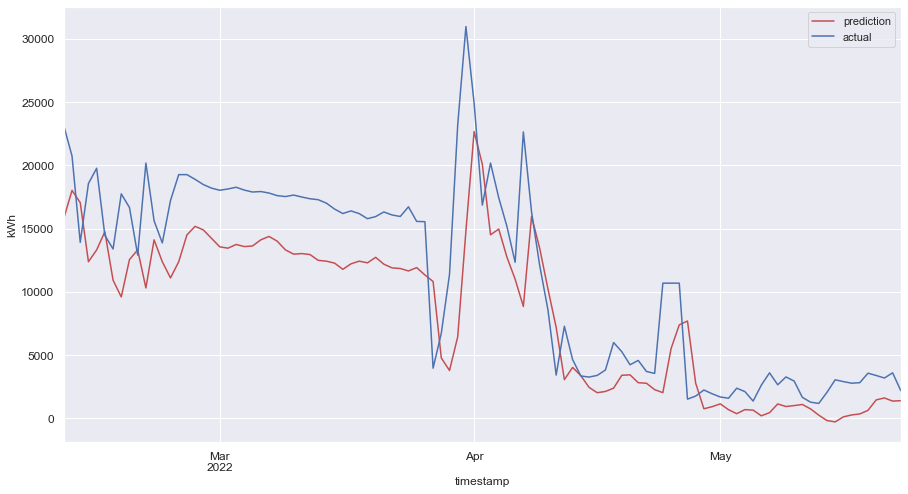

In [617]:
eval_df.plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.show()

### SARIMAX Gaz <a class="anchor" id="Gaz_stat"></a>

In [833]:
adf, pa, *_  = adfuller(train_gaz['kWh'].dropna())
print("p-value adf : ", pa)

p-value adf :  0.07490987840452269


In [834]:
xd =  train_gaz['kWh'].diff(1)
adf, pa, *_  = adfuller(xd.dropna())
print("p-value adf : ", pa)

p-value adf :  1.6714530341717805e-16


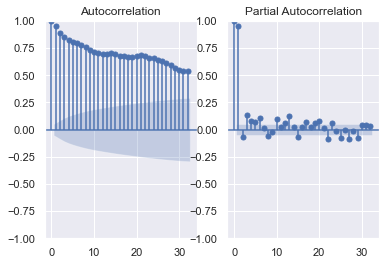

In [619]:
fig, ax = plt.subplots(1,2)
plot_acf(train_gaz['kWh'].dropna(), ax=ax[0]) 
plot_pacf(train_gaz['kWh'].dropna(), ax=ax[1]);

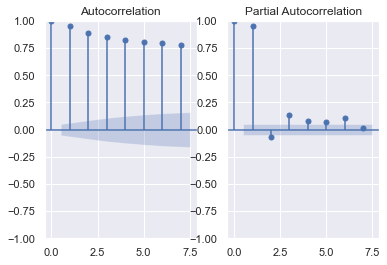

In [656]:
fig, ax = plt.subplots(1,2)
plot_acf(train_gaz['kWh'].dropna(), ax=ax[0],lags=7) 
plot_pacf(train_gaz['kWh'].dropna(), ax=ax[1],lags=7);

<AxesSubplot:>

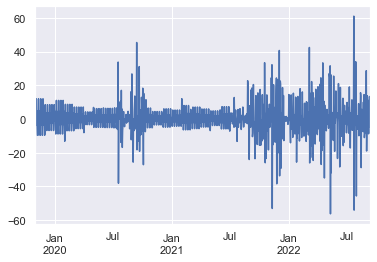

In [623]:
xd.plot()

In [624]:
train, test = temporal_train_test_split(train_gaz, test_size=120)

In [669]:
endog = train['kWh']
exog = pd.DataFrame(index=train.index, columns=['tmoy', 'Humidité'])
exog['tmoy']=train['tmoy']
exog['Humidité'] = train['Humidité']

mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,7), seasonal_order=(7,2,0,7))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                kWh   No. Observations:                 1334
Model:             SARIMAX(1, 0, 7)x(7, 2, [], 7)   Log Likelihood              -12406.004
Date:                            Sun, 06 Nov 2022   AIC                          24848.009
Time:                                    01:19:05   BIC                          24941.346
Sample:                                06-01-2018   HQIC                         24883.002
                                     - 01-24-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmoy        -797.4297     50.524    -15.783      0.000    -896.456    -698.404
Humidité     -12.7769      7.596   

In [670]:
exog_future = pd.DataFrame(index=test.index, columns=['tmoy', 'Humidité'])
exog_future['tmoy'] = test['tmoy']
exog_future['Humidité'] = test['Humidité']

In [671]:
predictions = res.forecast(120, exog=exog_future)

In [672]:
predictions.index.name = 'Date'

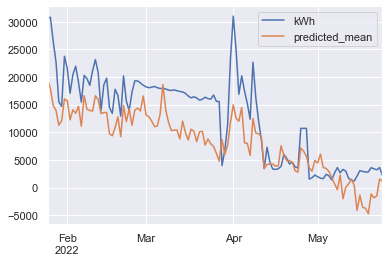

In [673]:
out = pd.concat([train_gaz.loc[test.index,'kWh'], predictions],axis=1).plot()

In [674]:
smape_loss(train_gaz.loc[test.index,'kWh'], predictions)

0.5271728227481001